In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import matplotlib
import re
import os
import datetime
import importlib
import logreg_binning

importlib.reload(logreg_binning)

<module 'logreg_binning' from '/Users/xulinchen/Documents/Dolplayground/logistic_regression/logreg_binning.py'>

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('my_all_time_loan_book_20032020.csv')

#Replace space with underscore
df.columns = df.columns.str.replace(' ', '_')

#Convert object to date type
df['Acquired'] = pd.to_datetime(df['Acquired'])
df['Acquired_ym'] = pd.to_datetime(df['Acquired']).dt.strftime('%Y-%m')
    
print('---- Target Creation started ----')
df['target'] = (df['Loan_status']=="Default").astype(int)

print('Number of bads is : ', df['target'].sum())
print('Number of goods is : ', (df['target']==0).sum())
print('bad rate is : {:.2%}'.format(df['target'].mean()))
print('---- Target Creation completed ----')
print('\n')

---- Target Creation started ----
Number of bads is :  11
Number of goods is :  895
bad rate is : 1.21%
---- Target Creation completed ----




### Data Quality Review (Goal: Obtain descriptive statistics for useful features)
- Remove useless columns: ID, target, date, cols with only 1 value, duplicated columns
- Split columns by numeric and non-numeric
- Create descriptive statistics for both types of columns

In [58]:
print('Start with {} total columns'.format(df.shape[1]))
target_col = ['target']
print('Removing taret column: ', target_col)
id_col = ['Borrower_ID']
print('Removing ID columns: ', id_col)
date_cols = [x for x in df.columns if 'date' in str.lower(x)] + df.select_dtypes(include=[np.datetime64]).columns.tolist()
print('Removing date type columns: ', date_cols)
uniform_value_col = df.nunique()[df.nunique()==1].index.tolist()
print('Removing uniform value columns: ', uniform_value_col)
dup_col = df.columns[df.columns.duplicated()].tolist()
print('Removing duplicated columns: ', dup_col)

cols_to_remove = target_col + date_cols + id_col + uniform_value_col + dup_col
eligible_cols = [x for x in df.columns if x not in cols_to_remove]
print('Ended with {} eligible columns'.format(len(eligible_cols)))

numeric_cols = df[eligible_cols].select_dtypes(include=np.number).columns.tolist()
print('{} numeric columns'.format(len(numeric_cols)))

object_cols = df[eligible_cols].select_dtypes(exclude=np.number).columns.tolist()
print('{} categorical or mixed type columns'.format(len(object_cols)))


Start with 34 total columns
Removing taret column:  ['target']
Removing ID columns:  ['Borrower_ID']
Removing date type columns:  ['Transaction_date', 'Loan_start_date', 'Last_repayment_date', 'Default_date', 'Acquired']
Removing uniform value columns:  ['Product', 'Covered_by_Safeguard', 'Default_price', 'Type_of_asset']
Removing duplicated columns:  []
Ended with 23 eligible columns
17 numeric columns
6 categorical or mixed type columns


In [59]:
numeric_col_summary = df[numeric_cols].describe().transpose()
numeric_col_summary['N_missing_perc'] = (df[numeric_cols].isnull().sum()/df.shape[0]).map(lambda x: "{0:.2f}%".format(x * 100))
numeric_col_summary['N_unique'] = df[numeric_cols].nunique()
numeric_col_summary.sort_values(by = 'N_unique')

,count,mean,std,min,25%,50%,75%,max,N_missing_perc,N_unique
Term,906.0,47.005519,16.479922,10.000000,36.000000,60.000000,60.000000,60.000000,0.00%,10
Loan_servicing_fee,906.0,0.009949,0.018801,0.000000,0.003000,0.003000,0.006000,0.099300,0.00%,26
Repayment_day,906.0,16.171082,10.076858,1.000000,6.000000,18.000000,25.750000,31.000000,0.00%,31
Amount_in_arrears,906.0,0.072526,0.461596,0.000000,0.000000,0.000000,0.000000,5.615609,0.00%,41
Loan_size,906.0,10913.133675,6598.437644,531.000000,5500.000000,10000.000000,15000.000000,25000.000000,0.00%,132
Borrower_origination_fee,906.0,286.302428,402.105389,0.000000,0.000000,110.000000,420.000000,2170.000000,0.00%,135
Transaction_price,168.0,9.436476,4.381308,0.772758,7.143041,8.915351,10.000000,29.070683,81.46%,135
Amount_invested,906.0,14.960798,7.134370,0.772758,10.000000,10.000000,20.000000,30.000000,0.00%,135
Borrower_rate,906.0,0.092024,0.068158,0.028400,0.033325,0.072400,0.132725,0.320200,0.00%,391
Investor_rate,906.0,0.082075,0.067245,0.021400,0.028925,0.050450,0.128075,0.310200,0.00%,416


In [9]:
object_col_summary = df[object_cols].describe().transpose()
object_col_summary['N_missing_perc'] = (df[object_cols].isnull().sum()/df.shape[0]).map(lambda x: "{0:.2f}%".format(x * 100))
object_col_summary['N_unique'] = df[object_cols].nunique()
object_col_summary.sort_values(by = 'N_unique')

,count,unique,top,freq,N_missing_perc,N_unique
Type_of_loan,906,2,Unsecured,891,0.00%,2
Days_in_arrears,41,4,>90 days,28,95.47%,4
Market,906,7,A*,425,0.00%,7
Loan_status,906,7,Withdrawn,671,0.00%,7
Loan_purpose,906,15,Consolidate existing debts,263,0.00%,15
Comment,136,135,[25/10/2019] Early Settlement made via debit c...,2,84.99%,135


### Using woe and iv for data profiling
- To understand univariate relationship between x and y
- To guide data cleaning
- To build baseline logistic regression model

In [89]:
pd.options.display.float_format = '{:,.6f}'.format

In [120]:
#If any feature has special value that's meant to be treated as categorical bins, list it here
special_values_list = [[] for _ in range(len(numeric_cols))]
special_values_dict = dict(zip(numeric_cols, special_values_list))
special_values_dict

{'Term': [],
 'Loan_size': [],
 'Borrower_origination_fee': [],
 'Borrower_rate': [],
 'Loan_servicing_fee': [],
 'Investor_rate': [],
 'Transaction_price': [],
 'Amount_invested': [],
 'Capital_outstanding': [],
 'Interest_outstanding': [],
 'Amount_repaid': [],
 'Capital_repaid': [],
 'Interest_repaid': [],
 'Amount_in_arrears': [],
 'Repayment_day': [],
 'Monthly_repayment_amount': [],
 'Percentage_repaid': []}

#### Numeric feature binning
- Missing value in numeric features is treated as a separate group
- Coarse class: 0 bad will be grouped with nearby bins based on woe distance
- Coarse class: monotonicity is forced through iterations until it's reached

num of bins is  6
0.Fineclass
IV is 0.17877518670933576


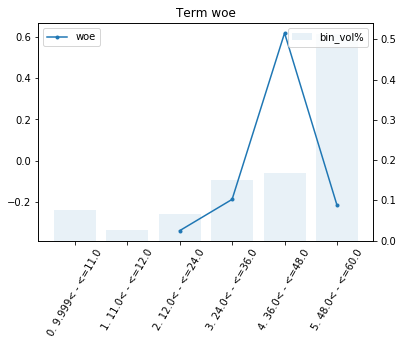

1. Coarseclass Group 0 Bad bins
IV is 0.2549250930436984


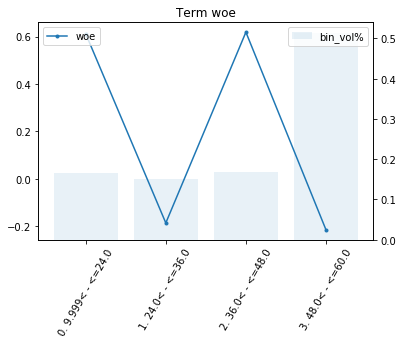

feature and target correlation is 0.02872191271803601, woe should decrease as feature increase
input bin edges :  [ 9.999 24.    36.    48.    60.   ] 
 dropping index [1]
output bin edges :  [ 9.999 36.    48.    60.   ]
2. Coarseclass Group non-mono bins round 1
IV is 0.16369378202907336


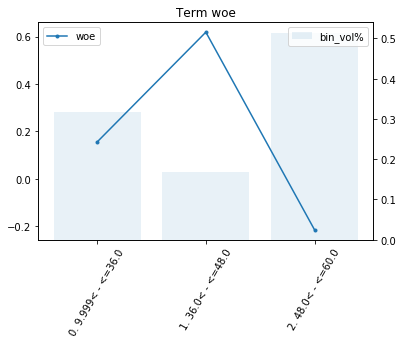

feature and target correlation is 0.02872191271803601, woe should decrease as feature increase
input bin edges :  [ 9.999 36.    48.    60.   ] 
 dropping index [1]
output bin edges :  [ 9.999 48.    60.   ]
2. Coarseclass Group non-mono bins round 2
IV is 0.12554204380056408


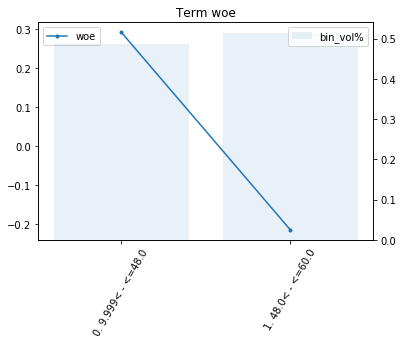

feature and target correlation is 0.02872191271803601, woe should decrease as feature increase
input bin edges :  [ 9.999 48.    60.   ] 
 dropping index []
output bin edges :  [ 9.999 48.    60.   ]
woe encoding {'0. 9.999< - <=48.0': 0.29241943675265875, '1. 48.0< - <=60.0': -0.21578838447125306}
num of bins is  17
0.Fineclass
IV is 0.5440538204199906


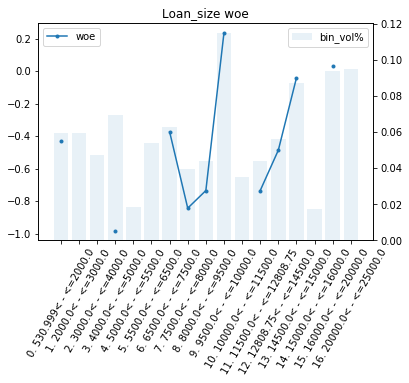

1. Coarseclass Group 0 Bad bins
IV is 0.46360915274409653


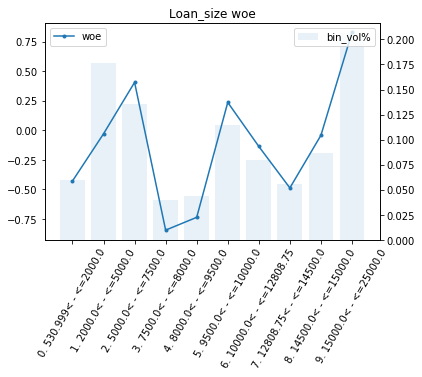

feature and target correlation is -0.022227404098778946, woe should increase as feature increase
input bin edges :  [  530.999  2000.     5000.     7500.     8000.     9500.    10000.
 12808.75  14500.    15000.    25000.   ] 
 dropping index [2 6 7]
output bin edges :  [  530.999  2000.     7500.     8000.     9500.    14500.    15000.
 25000.   ]
2. Coarseclass Group non-mono bins round 1
IV is 0.3927003467619584


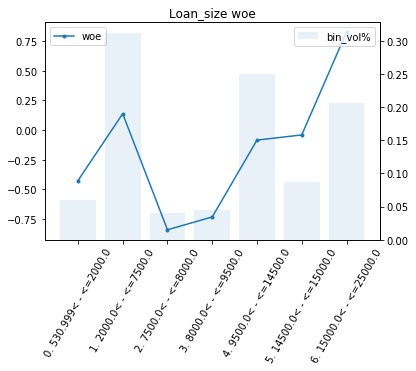

feature and target correlation is -0.022227404098778946, woe should increase as feature increase
input bin edges :  [  530.999  2000.     7500.     8000.     9500.    14500.    15000.
 25000.   ] 
 dropping index [1]
output bin edges :  [  530.999  7500.     8000.     9500.    14500.    15000.    25000.   ]
2. Coarseclass Group non-mono bins round 2
IV is 0.3549054117687106


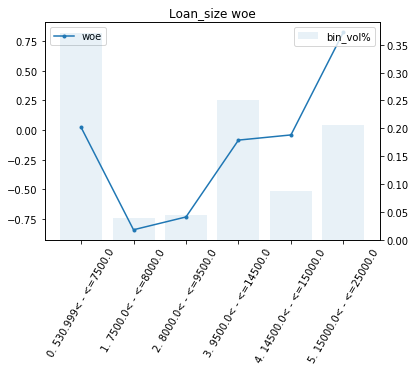

feature and target correlation is -0.022227404098778946, woe should increase as feature increase
input bin edges :  [  530.999  7500.     8000.     9500.    14500.    15000.    25000.   ] 
 dropping index [1]
output bin edges :  [  530.999  8000.     9500.    14500.    15000.    25000.   ]
2. Coarseclass Group non-mono bins round 3
IV is 0.27581809651739564


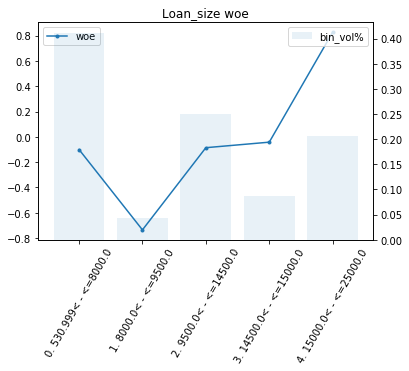

feature and target correlation is -0.022227404098778946, woe should increase as feature increase
input bin edges :  [  530.999  8000.     9500.    14500.    15000.    25000.   ] 
 dropping index [1]
output bin edges :  [  530.999  9500.    14500.    15000.    25000.   ]
2. Coarseclass Group non-mono bins round 4
IV is 0.23049807305484687


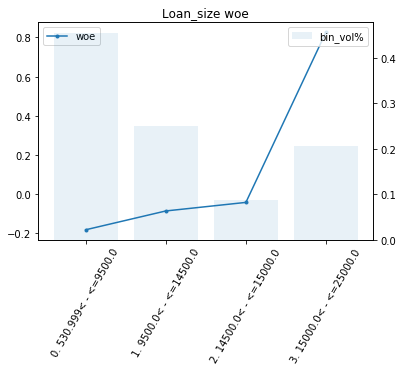

feature and target correlation is -0.022227404098778946, woe should increase as feature increase
input bin edges :  [  530.999  9500.    14500.    15000.    25000.   ] 
 dropping index []
output bin edges :  [  530.999  9500.    14500.    15000.    25000.   ]
woe encoding {'0. 530.999< - <=9500.0': -0.18187472926194473, '1. 9500.0< - <=14500.0': -0.0858946822895545, '2. 14500.0< - <=15000.0': -0.0422196187868931, '3. 15000.0< - <=25000.0': 0.8268182282367165}
num of bins is  14
0.Fineclass
IV is 1.675493075267305


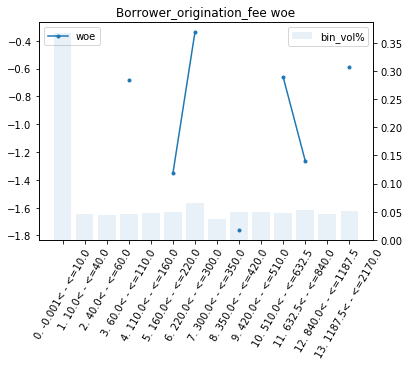

1. Coarseclass Group 0 Bad bins
IV is 2.34292315660659


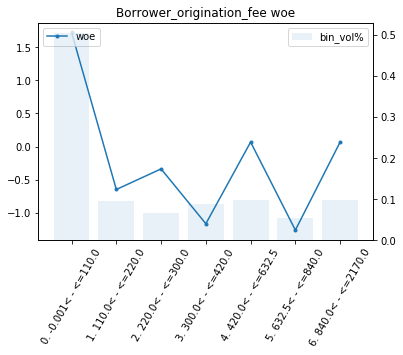

feature and target correlation is 0.0579469523340289, woe should decrease as feature increase
input bin edges :  [-1.000e-03  1.100e+02  2.200e+02  3.000e+02  4.200e+02  6.325e+02
  8.400e+02  2.170e+03] 
 dropping index [2 3 6]
output bin edges :  [-1.000e-03  1.100e+02  4.200e+02  6.325e+02  2.170e+03]
2. Coarseclass Group non-mono bins round 1
IV is 2.0766958150997312


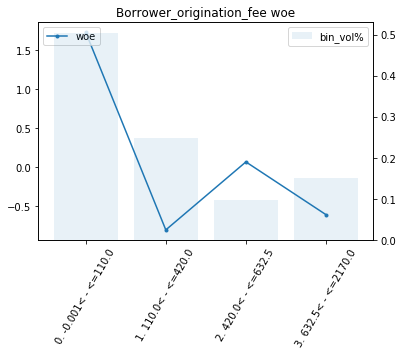

feature and target correlation is 0.0579469523340289, woe should decrease as feature increase
input bin edges :  [-1.000e-03  1.100e+02  4.200e+02  6.325e+02  2.170e+03] 
 dropping index [2]
output bin edges :  [-1.000e-03  1.100e+02  6.325e+02  2.170e+03]
2. Coarseclass Group non-mono bins round 2
IV is 1.9595349439564516


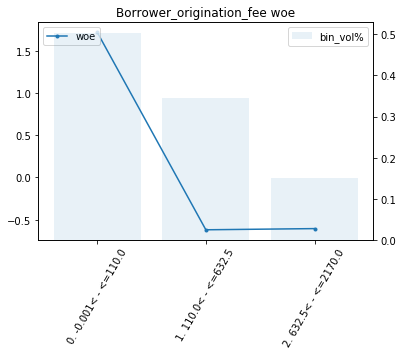

feature and target correlation is 0.0579469523340289, woe should decrease as feature increase
input bin edges :  [-1.000e-03  1.100e+02  6.325e+02  2.170e+03] 
 dropping index [2]
output bin edges :  [-1.00e-03  1.10e+02  2.17e+03]
2. Coarseclass Group non-mono bins round 3
IV is 1.9594766795235077


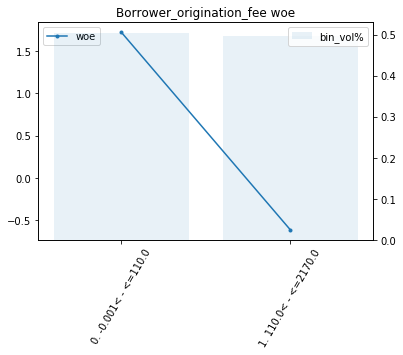

feature and target correlation is 0.0579469523340289, woe should decrease as feature increase
input bin edges :  [-1.00e-03  1.10e+02  2.17e+03] 
 dropping index []
output bin edges :  [-1.00e-03  1.10e+02  2.17e+03]
woe encoding {'0. -0.001< - <=110.0': 1.7235643640379013, '1. 110.0< - <=2170.0': -0.6170141253953593}
num of bins is  18
0.Fineclass
IV is 1.4808879340531882


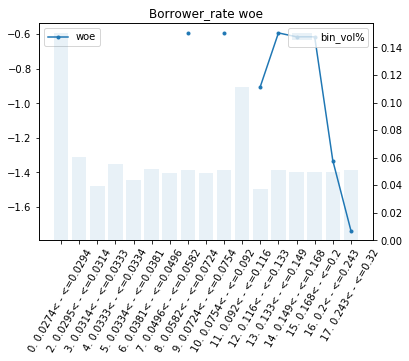

1. Coarseclass Group 0 Bad bins
IV is 2.7914667992373605


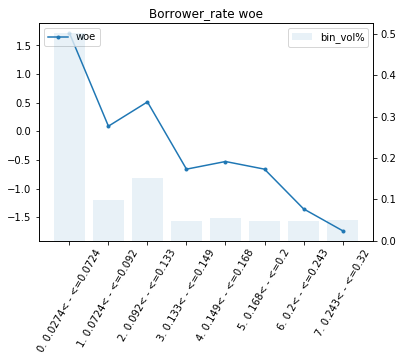

feature and target correlation is 0.13640041507594283, woe should decrease as feature increase
input bin edges :  [0.0274 0.0724 0.092  0.133  0.149  0.168  0.2    0.243  0.3202] 
 dropping index [2 4]
output bin edges :  [0.0274 0.0724 0.133  0.168  0.2    0.243  0.3202]
2. Coarseclass Group non-mono bins round 1
IV is 2.771047020536545


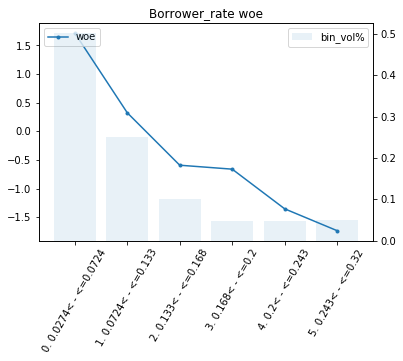

feature and target correlation is 0.13640041507594283, woe should decrease as feature increase
input bin edges :  [0.0274 0.0724 0.133  0.168  0.2    0.243  0.3202] 
 dropping index []
output bin edges :  [0.0274 0.0724 0.133  0.168  0.2    0.243  0.3202]
woe encoding {'0. 0.0274< - <=0.0724': 1.716963680006549, '1. 0.0724< - <=0.133': 0.32402477616799, '2. 0.133< - <=0.168': -0.592265955706165, '3. 0.168< - <=0.2': -0.6612588271931165, '4. 0.2< - <=0.243': -1.3544060077530617, '5. 0.243< - <=0.32': -1.736340618451032}
num of bins is  6
0.Fineclass
IV is 0.8199901159020688


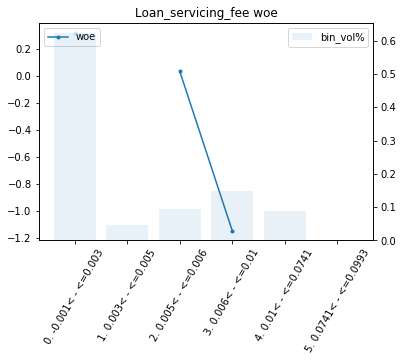

1. Coarseclass Group 0 Bad bins
IV is 0.4376546401728779


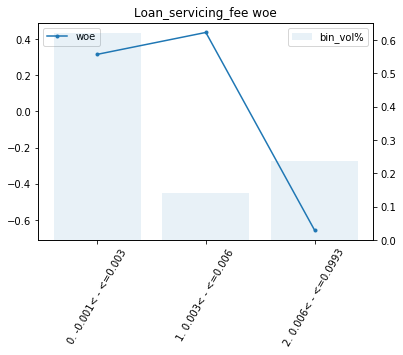

feature and target correlation is -0.020616890943030493, woe should increase as feature increase
input bin edges :  [-0.001   0.003   0.006   0.0993] 
 dropping index [1]
output bin edges :  [-0.001   0.006   0.0993]
2. Coarseclass Group non-mono bins round 1
IV is 0.43485999019143684


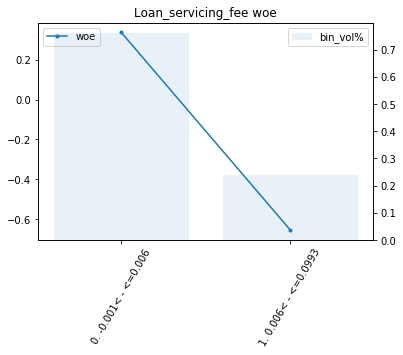

feature and target correlation is -0.020616890943030493, woe should increase as feature increase
input bin edges :  [-0.001   0.006   0.0993] 
 dropping index [1]
output bin edges :  [-0.001   0.0993]
2. Coarseclass Group non-mono bins round 2
IV is 0.0


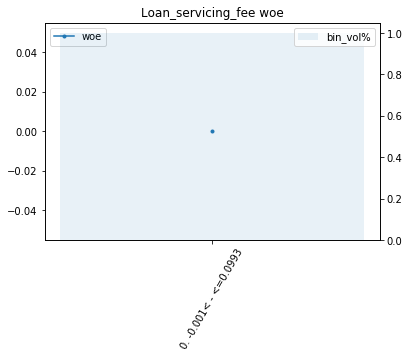

feature and target correlation is -0.020616890943030493, woe should increase as feature increase
input bin edges :  [-0.001   0.0993] 
 dropping index []
output bin edges :  [-0.001   0.0993]
woe encoding {'0. -0.001< - <=0.0993': 0.0}
num of bins is  20
0.Fineclass
IV is 1.6931577133660825


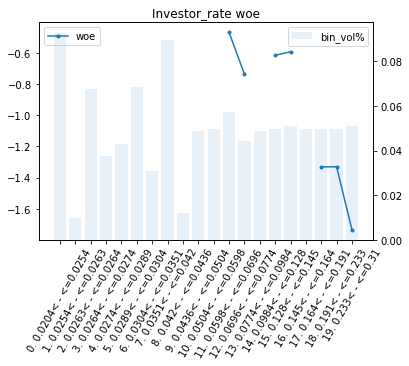

1. Coarseclass Group 0 Bad bins
IV is 3.3529599552148914


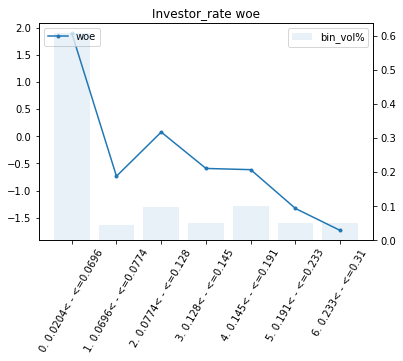

feature and target correlation is 0.14401645363596513, woe should decrease as feature increase
input bin edges :  [0.0204 0.0696 0.0774 0.128  0.145  0.191  0.233  0.3102] 
 dropping index [2]
output bin edges :  [0.0204 0.0696 0.128  0.145  0.191  0.233  0.3102]
2. Coarseclass Group non-mono bins round 1
IV is 3.3019727447773777


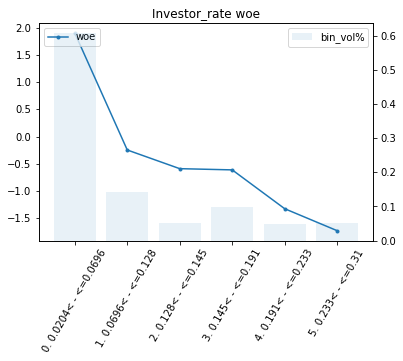

feature and target correlation is 0.14401645363596513, woe should decrease as feature increase
input bin edges :  [0.0204 0.0696 0.128  0.145  0.191  0.233  0.3102] 
 dropping index []
output bin edges :  [0.0204 0.0696 0.128  0.145  0.191  0.233  0.3102]
woe encoding {'0. 0.0204< - <=0.0696': 1.9091699960330457, '1. 0.0696< - <=0.128': -0.24788853957783902, '2. 0.128< - <=0.145': -0.592265955706165, '3. 0.145< - <=0.191': -0.6147388115582237, '4. 0.191< - <=0.233': -1.3308755103428678, '5. 0.233< - <=0.31': -1.736340618451032}
num of bins is  18
0.Fineclass
IV is 0.07804857306043454


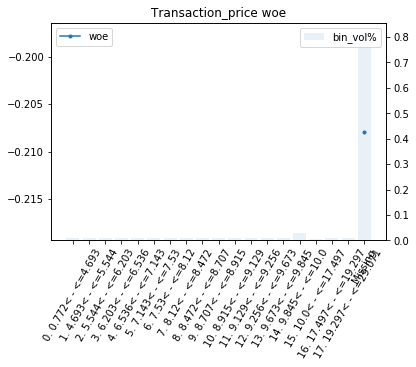

1. Coarseclass Group 0 Bad bins
IV is 0.07804857306043454


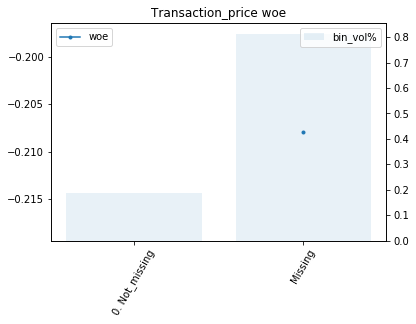

woe encoding {'0. Not_missing': 0.0, 'Missing': -0.20789724074133603}
num of bins is  5
0.Fineclass
IV is 0.10994445466481856


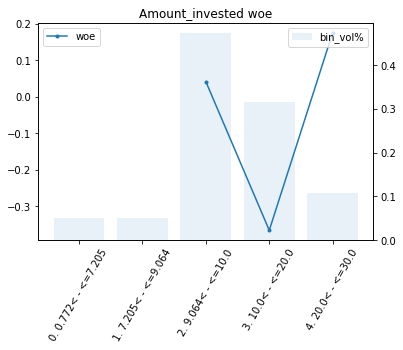

1. Coarseclass Group 0 Bad bins
IV is 0.16636047256202616


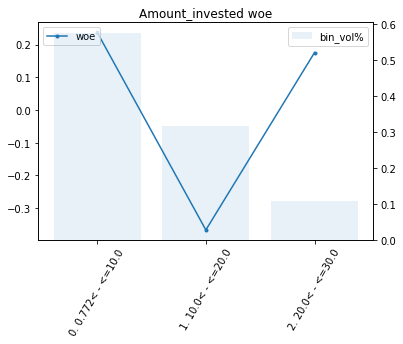

feature and target correlation is 0.021811046945181153, woe should decrease as feature increase
input bin edges :  [ 0.772 10.    20.    30.   ] 
 dropping index [2]
output bin edges :  [ 0.772 10.    30.   ]
2. Coarseclass Group non-mono bins round 1
IV is 0.11976870142181857


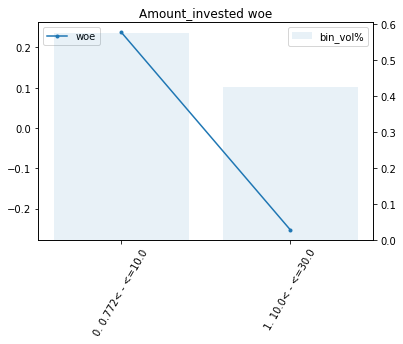

feature and target correlation is 0.021811046945181153, woe should decrease as feature increase
input bin edges :  [ 0.772 10.    30.   ] 
 dropping index []
output bin edges :  [ 0.772 10.    30.   ]
woe encoding {'0. 0.772< - <=10.0': 0.23774040757097742, '1. 10.0< - <=30.0': -0.2531517096221134}
num of bins is  16
0.Fineclass
IV is 2.7642404735839285


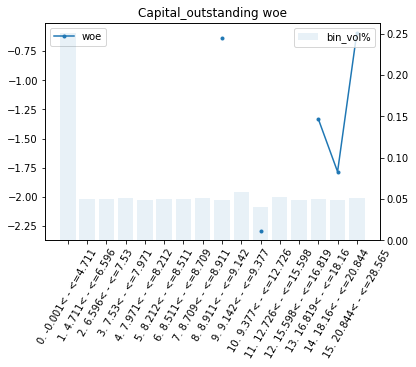

1. Coarseclass Group 0 Bad bins
IV is 3.7798931059194425


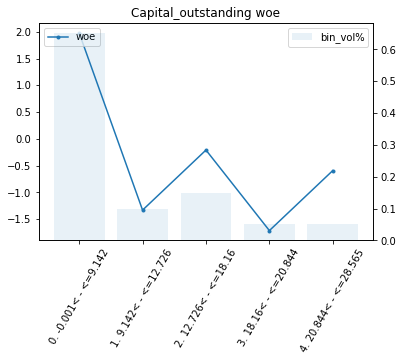

feature and target correlation is 0.11254410853870483, woe should decrease as feature increase
input bin edges :  [-1.00000000e-03  9.14200000e+00  1.27260000e+01  1.81600000e+01
  2.08440000e+01  2.85652835e+01] 
 dropping index [2 4]
output bin edges :  [-1.00000000e-03  9.14200000e+00  1.81600000e+01  2.85652835e+01]
2. Coarseclass Group non-mono bins round 1
IV is 3.411010163976677


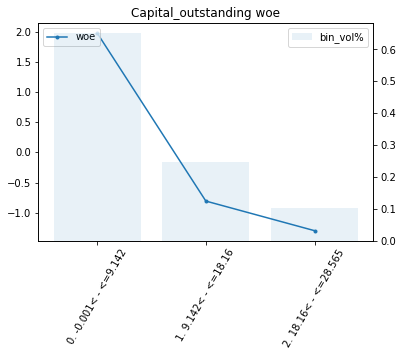

feature and target correlation is 0.11254410853870483, woe should decrease as feature increase
input bin edges :  [-1.00000000e-03  9.14200000e+00  1.81600000e+01  2.85652835e+01] 
 dropping index []
output bin edges :  [-1.00000000e-03  9.14200000e+00  1.81600000e+01  2.85652835e+01]
woe encoding {'0. -0.001< - <=9.142': 1.977798502422142, '1. 9.142< - <=18.16': -0.8061928519154508, '2. 18.16< - <=28.565': -1.2965864368642355}
num of bins is  16
0.Fineclass
IV is 3.8730940232526407


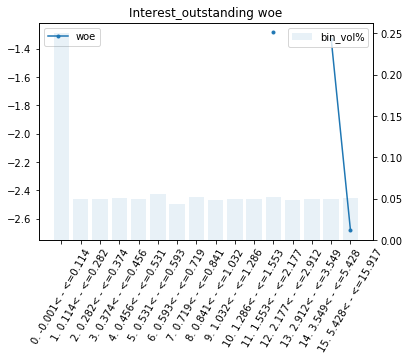

1. Coarseclass Group 0 Bad bins
IV is 5.047470807916607


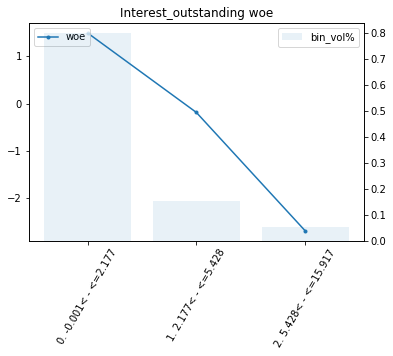

feature and target correlation is 0.27601000489692074, woe should decrease as feature increase
input bin edges :  [-1.0000e-03  2.1770e+00  5.4280e+00  1.5917e+01] 
 dropping index []
output bin edges :  [-1.0000e-03  2.1770e+00  5.4280e+00  1.5917e+01]
woe encoding {'0. -0.001< - <=2.177': 1.488563511248519, '1. 2.177< - <=5.428': -0.18680084759800064, '2. 5.428< - <=15.917': -2.6812769484021515}
num of bins is  20
0.Fineclass
IV is 1.828444068472803


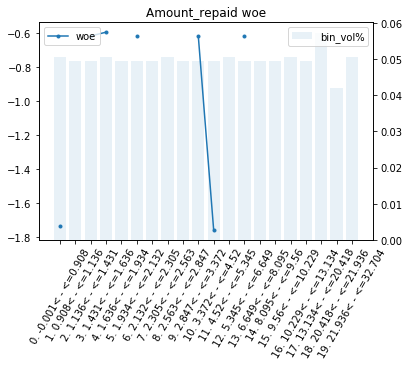

1. Coarseclass Group 0 Bad bins
IV is 2.9876161511086967


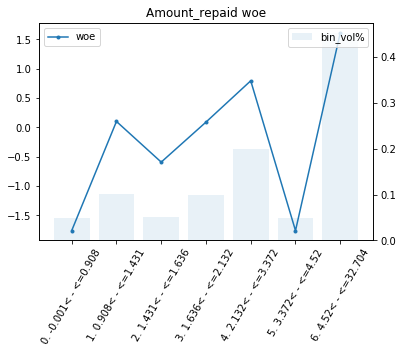

feature and target correlation is -0.06585538033950139, woe should increase as feature increase
input bin edges :  [-1.00000000e-03  9.08000000e-01  1.43100000e+00  1.63600000e+00
  2.13200000e+00  3.37200000e+00  4.52000000e+00  3.27041579e+01] 
 dropping index [2 4]
output bin edges :  [-1.00000000e-03  9.08000000e-01  1.63600000e+00  3.37200000e+00
  4.52000000e+00  3.27041579e+01]
2. Coarseclass Group non-mono bins round 1
IV is 2.8919349058634776


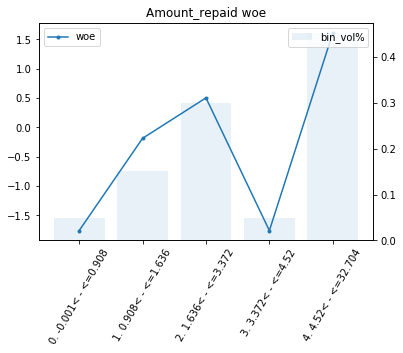

feature and target correlation is -0.06585538033950139, woe should increase as feature increase
input bin edges :  [-1.00000000e-03  9.08000000e-01  1.63600000e+00  3.37200000e+00
  4.52000000e+00  3.27041579e+01] 
 dropping index [2]
output bin edges :  [-1.00000000e-03  9.08000000e-01  3.37200000e+00  4.52000000e+00
  3.27041579e+01]
2. Coarseclass Group non-mono bins round 2
IV is 2.7989403899109764


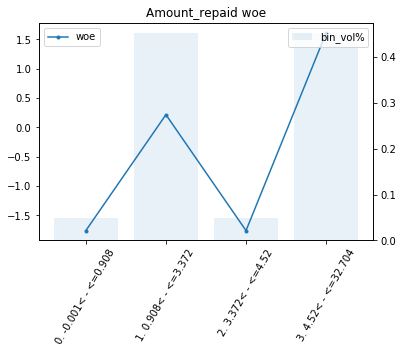

feature and target correlation is -0.06585538033950139, woe should increase as feature increase
input bin edges :  [-1.00000000e-03  9.08000000e-01  3.37200000e+00  4.52000000e+00
  3.27041579e+01] 
 dropping index [2]
output bin edges :  [-1.00000000e-03  9.08000000e-01  4.52000000e+00  3.27041579e+01]
2. Coarseclass Group non-mono bins round 3
IV is 2.033743590308087


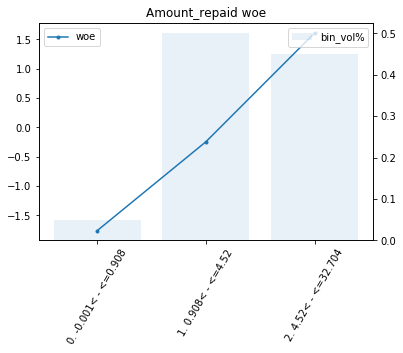

feature and target correlation is -0.06585538033950139, woe should increase as feature increase
input bin edges :  [-1.00000000e-03  9.08000000e-01  4.52000000e+00  3.27041579e+01] 
 dropping index []
output bin edges :  [-1.00000000e-03  9.08000000e-01  4.52000000e+00  3.27041579e+01]
woe encoding {'0. -0.001< - <=0.908': -1.7598711158612261, '1. 0.908< - <=4.52': -0.24451964251173408, '2. 4.52< - <=32.704': 1.60988473996611}
num of bins is  19
0.Fineclass
IV is 2.434107590019172


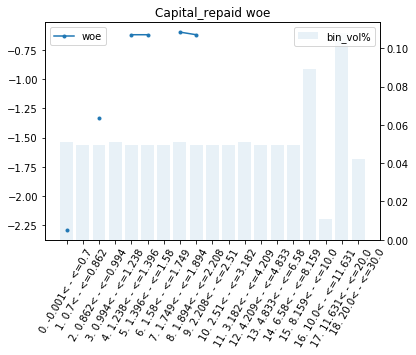

1. Coarseclass Group 0 Bad bins
IV is 3.9821555498814005


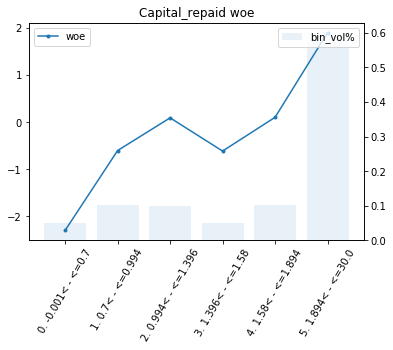

feature and target correlation is -0.07787808202345928, woe should increase as feature increase
input bin edges :  [-1.000e-03  7.000e-01  9.940e-01  1.396e+00  1.580e+00  1.894e+00
  3.000e+01] 
 dropping index [2]
output bin edges :  [-1.000e-03  7.000e-01  1.396e+00  1.580e+00  1.894e+00  3.000e+01]
2. Coarseclass Group non-mono bins round 1
IV is 3.927839809944482


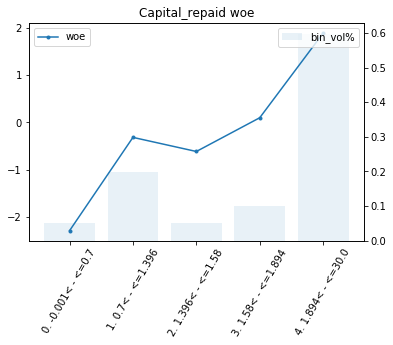

feature and target correlation is -0.07787808202345928, woe should increase as feature increase
input bin edges :  [-1.000e-03  7.000e-01  1.396e+00  1.580e+00  1.894e+00  3.000e+01] 
 dropping index [2]
output bin edges :  [-1.000e-03  7.000e-01  1.580e+00  1.894e+00  3.000e+01]
2. Coarseclass Group non-mono bins round 2
IV is 3.918316918959173


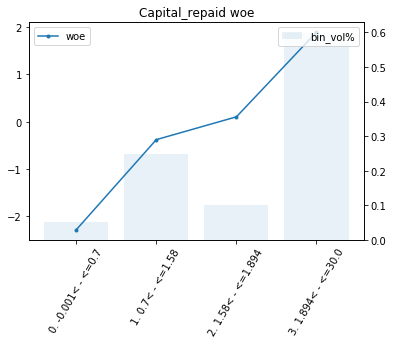

feature and target correlation is -0.07787808202345928, woe should increase as feature increase
input bin edges :  [-1.000e-03  7.000e-01  1.580e+00  1.894e+00  3.000e+01] 
 dropping index []
output bin edges :  [-1.000e-03  7.000e-01  1.580e+00  1.894e+00  3.000e+01]
woe encoding {'0. -0.001< - <=0.7': -2.2947942912062773, '1. 0.7< - <=1.58': -0.38254542472409603, '2. 1.58< - <=1.894': 0.10088122485378029, '3. 1.894< - <=30.0': 1.8963375559631614}
num of bins is  20
0.Fineclass
IV is 1.4669123791236638


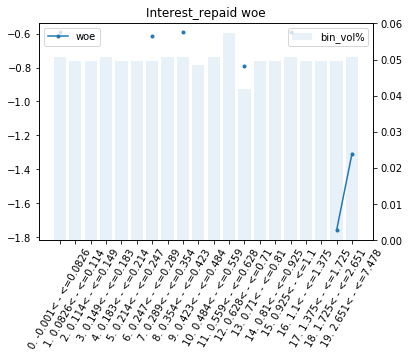

1. Coarseclass Group 0 Bad bins
IV is 0.9686365820692775


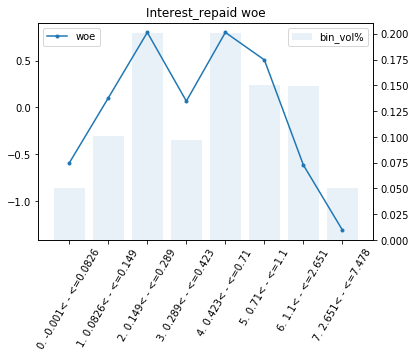

feature and target correlation is 0.08118761028853003, woe should decrease as feature increase
input bin edges :  [-1.000e-03  8.260e-02  1.490e-01  2.890e-01  4.230e-01  7.100e-01
  1.100e+00  2.651e+00  7.478e+00] 
 dropping index [1 1 4]
output bin edges :  [-1.000e-03  1.490e-01  2.890e-01  7.100e-01  1.100e+00  2.651e+00
  7.478e+00]
2. Coarseclass Group non-mono bins round 1
IV is 0.8686352816310938


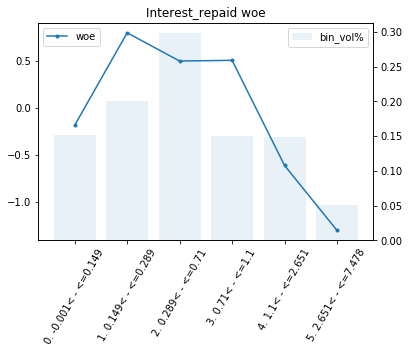

feature and target correlation is 0.08118761028853003, woe should decrease as feature increase
input bin edges :  [-1.000e-03  1.490e-01  2.890e-01  7.100e-01  1.100e+00  2.651e+00
  7.478e+00] 
 dropping index [1 3]
output bin edges :  [-1.000e-03  2.890e-01  1.100e+00  2.651e+00  7.478e+00]
2. Coarseclass Group non-mono bins round 2
IV is 0.7205178948896989


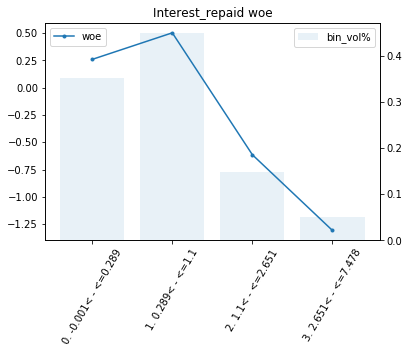

feature and target correlation is 0.08118761028853003, woe should decrease as feature increase
input bin edges :  [-1.000e-03  2.890e-01  1.100e+00  2.651e+00  7.478e+00] 
 dropping index [1]
output bin edges :  [-1.000e-03  1.100e+00  2.651e+00  7.478e+00]
2. Coarseclass Group non-mono bins round 3
IV is 0.7006816520419561


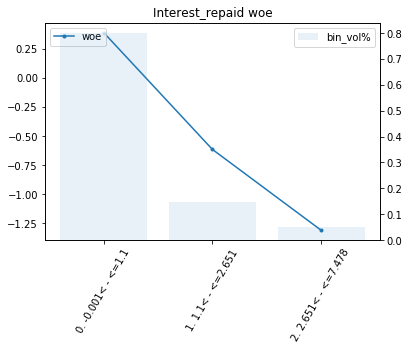

feature and target correlation is 0.08118761028853003, woe should decrease as feature increase
input bin edges :  [-1.000e-03  1.100e+00  2.651e+00  7.478e+00] 
 dropping index []
output bin edges :  [-1.000e-03  1.100e+00  2.651e+00  7.478e+00]
woe encoding {'0. -0.001< - <=1.1': 0.3871734430165069, '1. 1.1< - <=2.651': -0.6147388115582235, '2. 2.651< - <=7.478': -1.307885992118169}
num of bins is  1
0.Fineclass
IV is 0.0


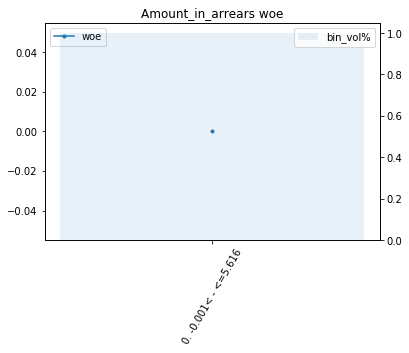

num of bins is  17
0.Fineclass
IV is 0.4497334050972074


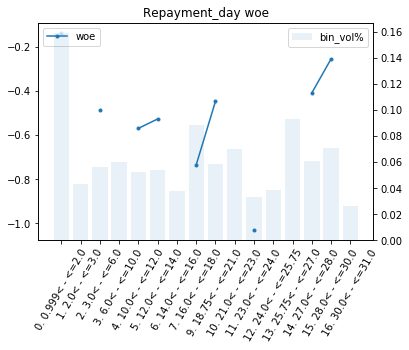

1. Coarseclass Group 0 Bad bins
IV is 0.28573673739147


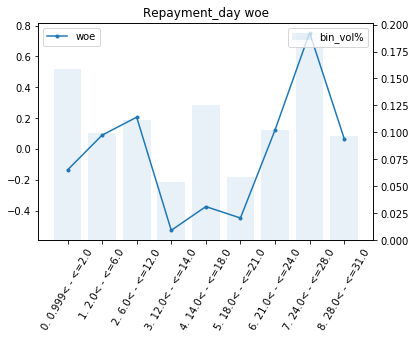

feature and target correlation is -0.004885348349617844, woe should increase as feature increase
input bin edges :  [ 0.999  2.     6.    12.    14.    18.    21.    24.    28.    31.   ] 
 dropping index [2 5 7]
output bin edges :  [ 0.999  2.    12.    14.    21.    28.    31.   ]
2. Coarseclass Group non-mono bins round 1
IV is 0.23790969061786246


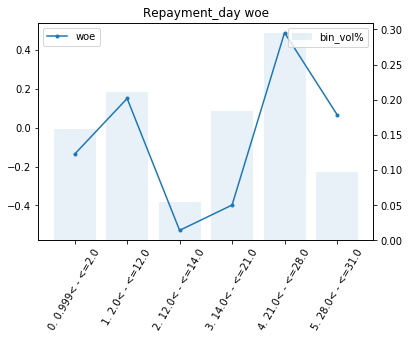

feature and target correlation is -0.004885348349617844, woe should increase as feature increase
input bin edges :  [ 0.999  2.    12.    14.    21.    28.    31.   ] 
 dropping index [1 5]
output bin edges :  [ 0.999 12.    14.    21.    31.   ]
2. Coarseclass Group non-mono bins round 2
IV is 0.1990059961515231


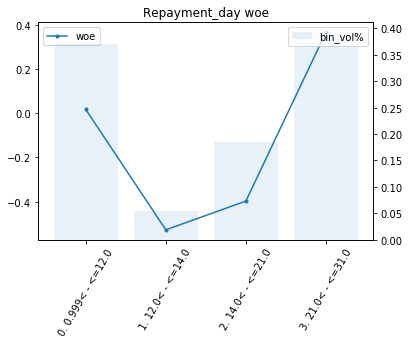

feature and target correlation is -0.004885348349617844, woe should increase as feature increase
input bin edges :  [ 0.999 12.    14.    21.    31.   ] 
 dropping index [1]
output bin edges :  [ 0.999 14.    21.    31.   ]
2. Coarseclass Group non-mono bins round 3
IV is 0.1638546357824262


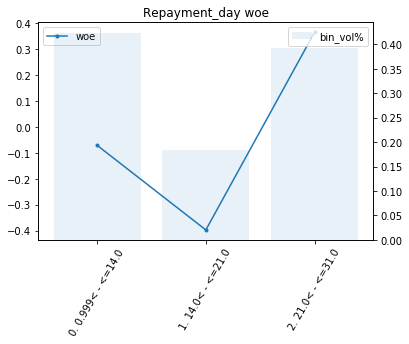

feature and target correlation is -0.004885348349617844, woe should increase as feature increase
input bin edges :  [ 0.999 14.    21.    31.   ] 
 dropping index [1]
output bin edges :  [ 0.999 21.    31.   ]
2. Coarseclass Group non-mono bins round 4
IV is 0.13198695093921364


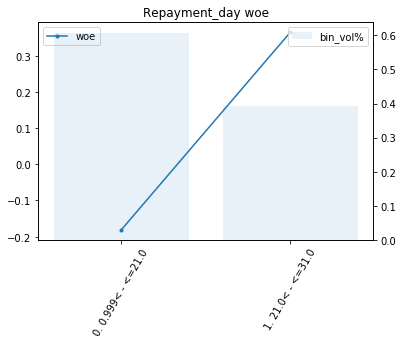

feature and target correlation is -0.004885348349617844, woe should increase as feature increase
input bin edges :  [ 0.999 21.    31.   ] 
 dropping index []
output bin edges :  [ 0.999 21.    31.   ]
woe encoding {'0. 0.999< - <=21.0': -0.18126066722238543, '1. 21.0< - <=31.0': 0.3660904414535026}
num of bins is  20
0.Fineclass
IV is 1.2520308787953238


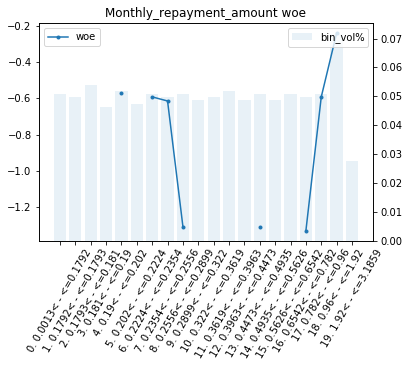

1. Coarseclass Group 0 Bad bins
IV is 0.9019717623065617


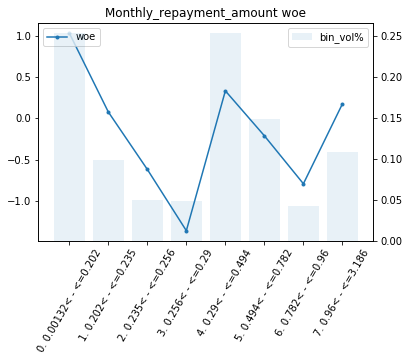

feature and target correlation is -0.005067464141621808, woe should increase as feature increase
input bin edges :  [1.3180e-03 2.0200e-01 2.3540e-01 2.5560e-01 2.8990e-01 4.9350e-01
 7.8200e-01 9.6000e-01 3.1859e+00] 
 dropping index [1 2 2 5 5]
output bin edges :  [1.3180e-03 2.5560e-01 2.8990e-01 7.8200e-01 9.6000e-01 3.1859e+00]
2. Coarseclass Group non-mono bins round 1
IV is 0.5576540099099114


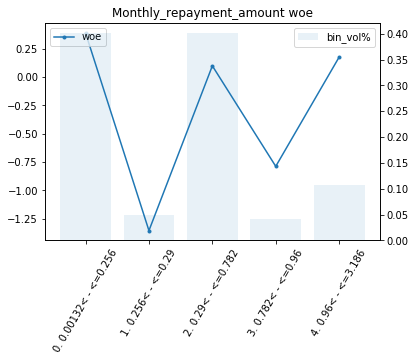

feature and target correlation is -0.005067464141621808, woe should increase as feature increase
input bin edges :  [1.3180e-03 2.5560e-01 2.8990e-01 7.8200e-01 9.6000e-01 3.1859e+00] 
 dropping index [1 3]
output bin edges :  [1.3180e-03 2.8990e-01 9.6000e-01 3.1859e+00]
2. Coarseclass Group non-mono bins round 2
IV is 0.006921961890331294


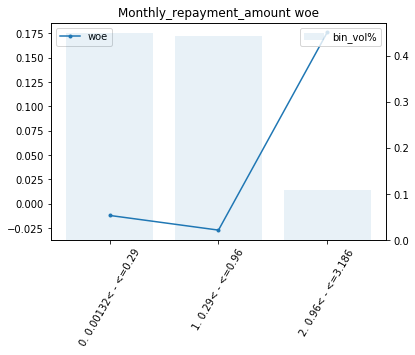

feature and target correlation is -0.005067464141621808, woe should increase as feature increase
input bin edges :  [1.3180e-03 2.8990e-01 9.6000e-01 3.1859e+00] 
 dropping index [1]
output bin edges :  [1.3180e-03 9.6000e-01 3.1859e+00]
2. Coarseclass Group non-mono bins round 3
IV is 0.00682016161222765


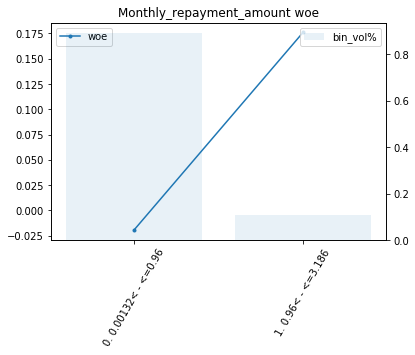

feature and target correlation is -0.005067464141621808, woe should increase as feature increase
input bin edges :  [1.3180e-03 9.6000e-01 3.1859e+00] 
 dropping index []
output bin edges :  [1.3180e-03 9.6000e-01 3.1859e+00]
woe encoding {'0. 0.00132< - <=0.96': -0.019404941020721815, '1. 0.96< - <=3.186': 0.175782533026898}
num of bins is  16
0.Fineclass
IV is 3.628511260473773


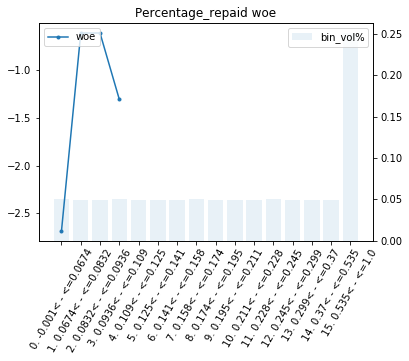

1. Coarseclass Group 0 Bad bins
IV is 5.380306774834427


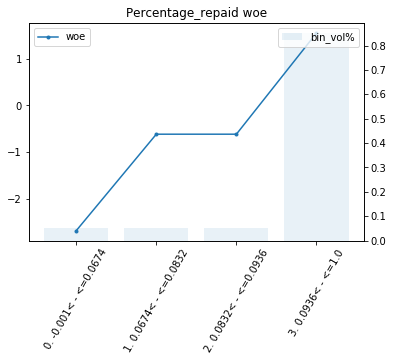

feature and target correlation is -0.10136656807414093, woe should increase as feature increase
input bin edges :  [-0.001   0.0674  0.0832  0.0936  1.    ] 
 dropping index [2]
output bin edges :  [-0.001   0.0674  0.0936  1.    ]
2. Coarseclass Group non-mono bins round 1
IV is 5.380306774834426


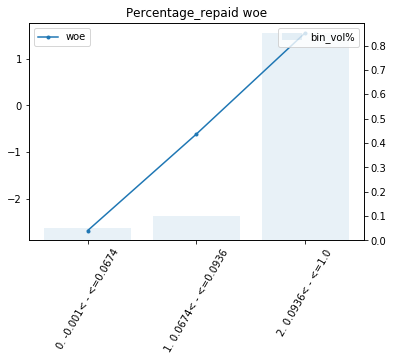

feature and target correlation is -0.10136656807414093, woe should increase as feature increase
input bin edges :  [-0.001   0.0674  0.0936  1.    ] 
 dropping index []
output bin edges :  [-0.001   0.0674  0.0936  1.    ]
woe encoding {'0. -0.001< - <=0.0674': -2.6812769484021515, '1. 0.0674< - <=0.0936': -0.6147388115582237, '2. 0.0936< - <=1.0': 1.551714107111242}


In [132]:
target = 'target'
fineclass_summary = pd.DataFrame()
coarseclass_summary = pd.DataFrame()
df_woe = pd.DataFrame()
woe_dict_all = {}
cols_to_check =[]

for feat in numeric_cols:
    #Initialisation
    eval_df_summary_fc = pd.DataFrame()
    eval_df_summary_cc = pd.DataFrame()
    
    ########## 0. Fineclass ############
    #missing value or special values are specified to be treated as categoricals, split to num and cat      
    s_num, s_cat = logreg_binning.split_num_cat(df[feat], special_values = special_values_dict[feat]) # if there is any special_values, use this function to specify it
    s_num_fc, num_bin_edges_fc = logreg_binning.num_fc(s_num, bin_num_fineclass =20)
    s_cat_fc, cat_bin_values_fc = logreg_binning.cat_fc(s_cat)
    s_fc = logreg_binning.combine_num_cat_fc(s_num_fc, s_cat_fc)
    eval_df_summary_fc = logreg_binning.bin_woe_iv(s_fc, df[target], '0.Fineclass')
        
    #Append to fineclass summary
    if fineclass_summary is None:
        fineclass_summary = eval_df_summary_fc
    else:
        fineclass_summary = fineclass_summary.append(eval_df_summary_fc)

    ########## Exception handling based on 0. Fineclass ############
    
    #if the feature has inf or missing iv, add it to cols_to_check and not proceed further
    if eval_df_summary_fc.loc[eval_df_summary_fc['feat']=='Total']['iv'].isin([0, np.inf]).values[0]:
        cols_to_check.append(feat)
        #finish grouping if feature has 0 or infinity iv in fineclass
    
    ########## 1. Coarseclass Group 0 Bad bins ############
    else:
        eval_df_summary_fc = eval_df_summary_fc.loc[eval_df_summary_fc['feat']!='Total']
        
        #if all numeric bins has 0 bad in total, group the numeric values into 1 bin as not missing
        if eval_df_summary_fc.loc[eval_df_summary_fc['feat_num_index'].notnull()]['N_bad'].sum()==0:
            s_num_cc =  s_num.astype('object')
            s_num_cc.values[:] = '0. Not_missing'
            
            s_cc = logreg_binning.combine_num_cat_fc(s_num_cc, s_cat_fc)
            eval_df_summary_cc = logreg_binning.bin_woe_iv(s_cc, df[target], desc = '1. Coarseclass Group 0 Bad bins')
            
            eval_df_summary_cc.loc[eval_df_summary_cc['feat']=='0. Not_missing', 'woe'] = 0

            #Append to coarseclass summary and finish grouping
            if coarseclass_summary is None:
                coarseclass_summary = eval_df_summary_cc
            else:
                coarseclass_summary = coarseclass_summary.append(eval_df_summary_cc)

            eval_df_summary_cc = eval_df_summary_cc.loc[eval_df_summary_cc['feat']!='Total']
            
        #if all numeric bins has >0 bad in total, and if any numeric bin has 0 bad, group 0 bad bin 
        elif np.any(eval_df_summary_fc.loc[eval_df_summary_fc['feat_num_index'].notnull()]['N_bad'],0):    
            num_bin_edges_cc = logreg_binning.num_cc_edges_nonzerobad(s_num, num_bin_edges_fc, eval_df_summary_fc)
            s_num_cc = logreg_binning.num_cc(s_num, num_bin_edges_cc)

            s_cc = logreg_binning.combine_num_cat_fc(s_num_cc, s_cat_fc)
            eval_df_summary_cc = logreg_binning.bin_woe_iv(s_cc, df[target], desc = '1. Coarseclass Group 0 Bad bins')

            #Append to coarseclass summary
            if coarseclass_summary is None:
                coarseclass_summary = eval_df_summary_cc
            else:
                coarseclass_summary = coarseclass_summary.append(eval_df_summary_cc)
                
            eval_df_summary_cc = eval_df_summary_cc.loc[eval_df_summary_cc['feat']!='Total']
            
            #If only 1 numeric bin, do not enforce monotonicity, Only when there are at least two numeric bins, enforce monotonicity
            if s_num_cc.nunique() >= 2:
                
                ########## 2. Enforce monotonicity ############
                #make the while loop start by makeing two arrays having unequal lengths
                num_bin_edges_cc_ori = np.append(num_bin_edges_cc, 'to make the while loop start running')
                round_count = 1
                while len(num_bin_edges_cc_ori) != len(num_bin_edges_cc):
                    num_bin_edges_cc_ori = num_bin_edges_cc
                    num_bin_edges_cc = logreg_binning.num_cc_edges_woe_enforce_monotonicity(s_num, df[target], num_bin_edges = num_bin_edges_cc, eval_df_summary = eval_df_summary_cc)
                    
                    #if it is already monotonic, do not save the result to summary
                    if len(num_bin_edges_cc_ori) != len(num_bin_edges_cc):
                        s_num_cc = logreg_binning.num_cc(s_num, num_bin_edges_cc)
                        s_cc = logreg_binning.combine_num_cat_fc(s_num_cc, s_cat_fc)
                        eval_df_summary_cc = logreg_binning.bin_woe_iv(s_cc, df[target], desc = '2. Coarseclass Group non-mono bins round ' + str(round_count))
                        
                        #Append to summary
                        if coarseclass_summary is None:
                            coarseclass_summary = eval_df_summary_cc
                        else:
                            coarseclass_summary = coarseclass_summary.append(eval_df_summary_cc)
                        
                        eval_df_summary_cc = eval_df_summary_cc.loc[eval_df_summary_cc['feat']!='Total']
                        
                        round_count = round_count + 1
                
    #If feature does not need to be checked, save result of coarclass if there is coarse class results, otherwise, use fineclass results
    if feat not in cols_to_check:
        if eval_df_summary_cc.empty:
            s_woe, woe_dict = logreg_binning.cc_to_woe(s_fc, eval_df_summary_fc)
        else:
            s_woe, woe_dict = logreg_binning.cc_to_woe(s_cc, eval_df_summary_cc)                

        df_woe = pd.concat([df_woe, s_woe], axis = 1)
        woe_dict_all[feat] = woe_dict

#### Categorical feature binning
- The solution below is designed for profiling or quick experimentation, it minimizes manual work, but it's not meant for final solution
- Bins with 0 bad (often caused by low volume) is assigned 0.01 bad for woe to be calculated. Woe is smoothened based on the number of goods in the bin. min_bin_count and smoothing factors are set up judgementally. min_bin_count = 20 means if there are 20 observations in the bin, woe is applied 50% weight. smoothing = 10 means if there are 10 more observations in the bin than min_bin_count, woe is applied 73% weight; 20 more observations -> woe is applied 88% weight; 30 more observations -> woe is applied 95% weight. So depending on how big the dataset is, min_bin_count and smoothing factors should be adjusted accordingly.
- For final solution, it is recommended that fineclass result to be checked for each categorical feature individually to guide manual coarse class

0.Fineclass
IV is 1.9038734794854049


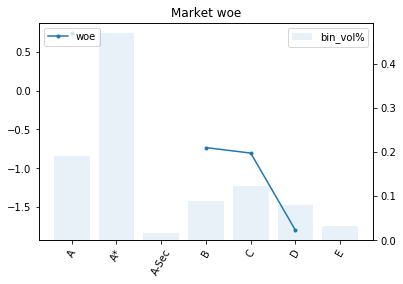

woe encoding {'A': 0.751289421548293, 'A*': 6.261054469903064, 'A-Sec': 1.1019775769218763, 'B': -0.7308316882417918, 'C': -0.8033881175935657, 'D': -1.7910696270727635, 'E': 2.5432758400182247}
0.Fineclass
IV is 0.0005665411442213395


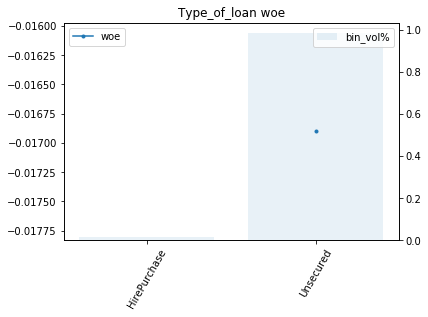

woe encoding {'HirePurchase': 1.1012919584010672, 'Unsecured': -0.01599313286638518}
0.Fineclass
IV is inf


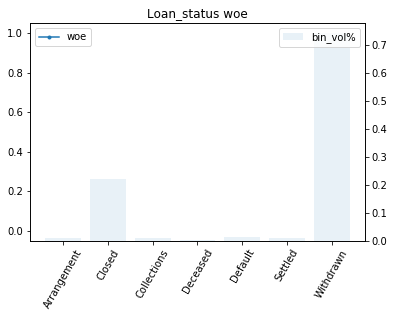

0.Fineclass
IV is 7.776647840366403


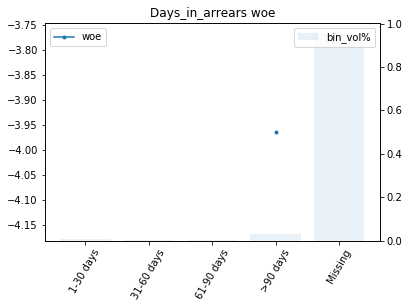

woe encoding {'1-30 days': 0.530326599361598, '31-60 days': 0.2022862511569104, '61-90 days': 0.12820412592036537, '>90 days': -2.732285564016216, 'Missing': 6.972601015494065}
0.Fineclass
IV is inf


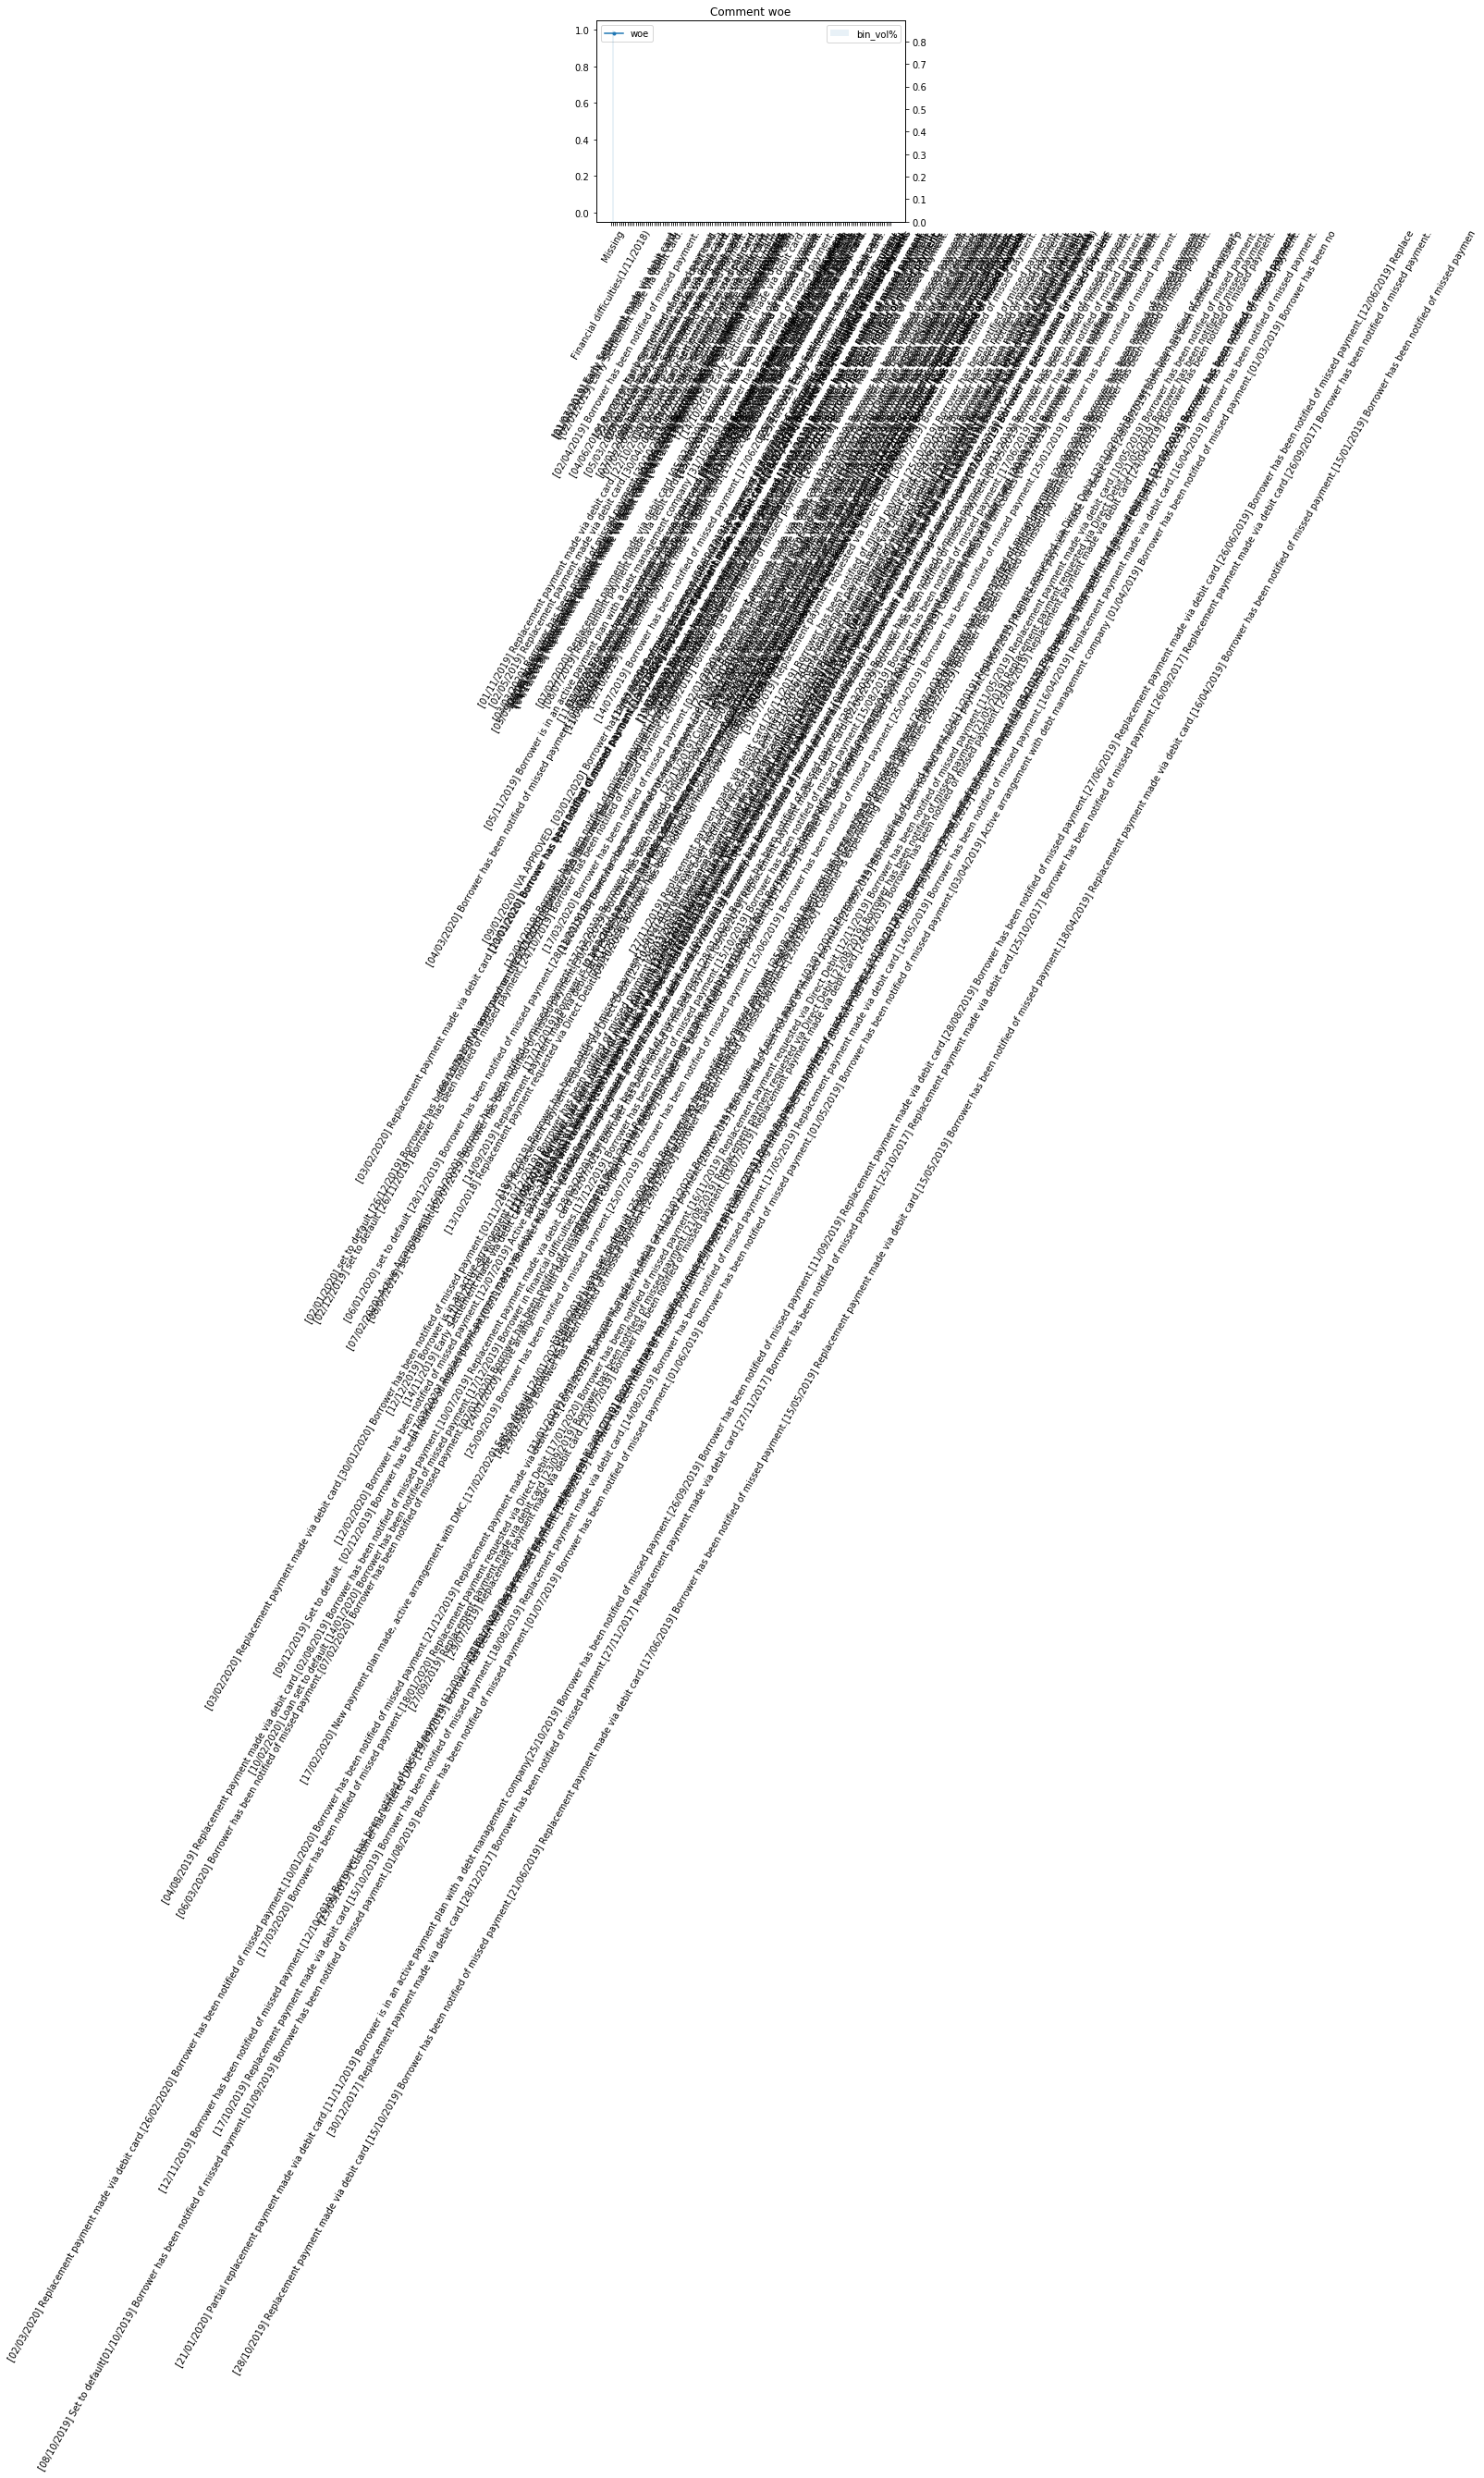

0.Fineclass
IV is 0.9089608939729544


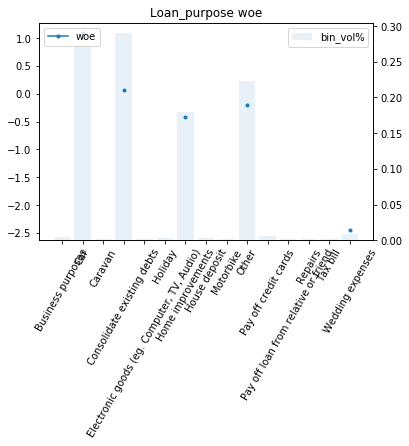

woe encoding {'Business purposes': 0.26926091011942405, 'Car': 1.1072896151492926, 'Caravan': 0.02803563427141883, 'Consolidate existing debts': 0.07219073238883204, 'Electronic goods (eg. Computer, TV, Audio)': 0.12897362828029052, 'Holiday': 0.20312417145191972, 'Home improvements': -0.41331682878287807, 'House deposit': 0.20312417145191972, 'Motorbike': 0.12897362828029052, 'Other': -0.19518607146636, 'Pay off credit cards': 0.3331494711007078, 'Pay off loan from relative or friend': 0.12897362828029052, 'Repairs': 0.12897362828029052, 'Tax bill': 0.02803563427141883, 'Wedding expenses': -0.5657181286086904}


In [133]:
object_cols = object_cols_ori
for feat in object_cols:    
    ########## 0. Fineclass ############
    s_cat_fc, cat_bin_values_fc = logreg_binning.cat_fc(df[feat])
    eval_df_summary_fc = logreg_binning.bin_woe_iv(s_cat_fc, df[target], '0.Fineclass')
        
    if fineclass_summary is None:
        fineclass_summary = eval_df_summary_fc
    else:
        fineclass_summary = fineclass_summary.append(eval_df_summary_fc)        
    
    ########## Exception handling based on 0. Fineclass ############
    #if the feature has inf or missing iv, add it to cols_to_check and not proceed further
    if eval_df_summary_fc.loc[eval_df_summary_fc['feat']=='Total']['iv'].isin([0, np.inf]).values[0]:
        cols_to_check.append(feat)
        
    else:
        ########## 1. Coarseclass smoothe 0 bad bin woe ############
        #if there is any categorical bin having 0 bad and 
        eval_df_summary_fc = eval_df_summary_fc.loc[eval_df_summary_fc['feat']!='Total']
            
        if eval_df_summary_fc.loc[((eval_df_summary_fc['N_bad']==0) & (eval_df_summary_fc['feat_num_index'].isnull())), 'woe'].shape[0]>0:
            eval_df_summary_cc = logreg_binning.cc_cat_zerobad_lowvolwoesmooth(cat_bin_values = cat_bin_values_fc, \
                                                                           eval_df_summary = eval_df_summary_fc, \
                                                                           min_bin_count=20, smoothing=10, min_n_bad = 0.01, desc = '1. Coarseclass smoothe 0 bad bin woe')
            
            #Append to summary
            if coarseclass_summary is None:
                coarseclass_summary = eval_df_summary_cc
            else:
                coarseclass_summary = coarseclass_summary.append(eval_df_summary_cc)
            
            eval_df_summary_cc = eval_df_summary_cc.loc[eval_df_summary_cc['feat']!='Total']
            
    #If feature does not need to be checked, save result of coarclass if there is coarse class results, otherwise, use fineclass results
    if feat not in cols_to_check:
        if eval_df_summary_cc.empty:
            s_woe, woe_dict = logreg_binning.cc_to_woe(s_cat_fc, eval_df_summary_fc)
        else:
            s_woe, woe_dict = logreg_binning.cc_to_woe(s_cat_fc, eval_df_summary_cc)                

        df_woe = pd.concat([df_woe, s_woe], axis = 1)
        woe_dict_all[feat] = woe_dict

### Outputs of this data profiling process has 
- iv_summary: at feature level, it contains the iv at each iteration of binning, the fine class and coarse class iv, which features need further check
- iv_summary_all: the artefacts of binning process at bin level, good for documentation or checking a feature
- df_woe: the features transformed to woe based on the fine/coarse class
- woe_dict_all: the dictionaries of feature bin to woe mapping

In [134]:
iv_summary_all = pd.concat([fineclass_summary, coarseclass_summary])
iv_summary = iv_summary_all.loc[iv_summary_all['feat']=='Total'][['var', 'desc','iv']].pivot(index='var', columns='desc', values='iv')
coarse_cols = [x for x in iv_summary.columns if 'Coarse' in x ]

iv_summary['dtype'] = ['numeric' if x in numeric_cols else 'object' for x in iv_summary.index]
iv_summary['cols_to_check'] = [True if x in cols_to_check else False for x in iv_summary.index]
cols = iv_summary.columns.tolist()
cols = cols[-2:] + cols[:-2]
iv_summary = iv_summary[cols]

iv_summary['iv_fine'] = iv_summary['0.Fineclass']
iv_summary['iv_coarse'] = iv_summary[coarse_cols].min(axis=1)

iv_summary.sort_values(by=['cols_to_check', 'iv_coarse', 'iv_fine'], ascending = [True, False, False])

desc,dtype,cols_to_check,0.Fineclass,1. Coarseclass Group 0 Bad bins,1. Coarseclass smoothe 0 bad bin woe,2. Coarseclass Group non-mono bins round 1,2. Coarseclass Group non-mono bins round 2,2. Coarseclass Group non-mono bins round 3,2. Coarseclass Group non-mono bins round 4,iv_fine,iv_coarse
var,,,,,,,,,,,
Days_in_arrears,object,False,3.888324,NaN,9.407980,NaN,NaN,NaN,NaN,3.888324,9.407980
Market,object,False,0.951937,NaN,4.008610,NaN,NaN,NaN,NaN,0.951937,4.008610
Percentage_repaid,numeric,False,1.814256,2.690153,NaN,2.690153,NaN,NaN,NaN,1.814256,2.690153
Interest_outstanding,numeric,False,1.936547,2.523735,NaN,NaN,NaN,NaN,NaN,1.936547,2.523735
Capital_repaid,numeric,False,1.217054,1.991078,NaN,1.963920,1.959158,NaN,NaN,1.217054,1.959158
Capital_outstanding,numeric,False,1.382120,1.889947,NaN,1.705505,NaN,NaN,NaN,1.382120,1.705505
Investor_rate,numeric,False,0.846579,1.676480,NaN,1.650986,NaN,NaN,NaN,0.846579,1.650986
Borrower_rate,numeric,False,0.740444,1.395733,NaN,1.385524,NaN,NaN,NaN,0.740444,1.385524
Amount_repaid,numeric,False,0.914222,1.493808,NaN,1.445967,1.399470,1.016872,NaN,0.914222,1.016872


In [135]:
iv_summary_all.loc[iv_summary_all['var']=='Market']

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv,var,desc,smoothing_factor
0,A,172.0,1.00,NaN,173.00,0.192179,0.090909,0.190949,0.748566,5.147494,0.005780,0.075807,Market,0.Fineclass,NaN
1,A*,425.0,0.00,NaN,425.00,0.474860,0.000000,0.469095,NaN,NaN,0.000000,NaN,Market,0.Fineclass,NaN
2,A-Sec,15.0,0.00,NaN,15.00,0.016760,0.000000,0.016556,NaN,NaN,0.000000,NaN,Market,0.Fineclass,NaN
3,B,78.0,2.00,NaN,80.00,0.087151,0.181818,0.088300,-0.735367,3.663562,0.025000,0.069615,Market,0.Fineclass,NaN
4,C,109.0,3.00,NaN,112.00,0.121788,0.272727,0.123620,-0.806193,3.592736,0.026786,0.121686,Market,0.Fineclass,NaN
5,D,67.0,5.00,NaN,72.00,0.074860,0.454545,0.079470,-1.803674,2.595255,0.069444,0.684828,Market,0.Fineclass,NaN
6,E,29.0,0.00,NaN,29.00,0.032402,0.000000,0.032009,NaN,NaN,0.000000,NaN,Market,0.Fineclass,NaN
7,Total,895.0,11.00,NaN,906.00,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.951937,Market,0.Fineclass,NaN
0,A,172.0,1.00,NaN,173.00,0.192179,0.090662,0.190943,0.751289,5.147494,0.005780,0.076269,Market,1. Coarseclass smoothe 0 bad bin woe,1.000000
1,A*,425.0,0.01,NaN,425.01,0.474860,0.000907,0.469090,6.261054,10.657259,0.000024,2.967450,Market,1. Coarseclass smoothe 0 bad bin woe,1.000000


In [136]:
woe_dict_all

{'Term': {'0. 9.999< - <=48.0': 0.29241943675265875,
  '1. 48.0< - <=60.0': -0.21578838447125306},
 'Loan_size': {'0. 530.999< - <=9500.0': -0.18187472926194473,
  '1. 9500.0< - <=14500.0': -0.0858946822895545,
  '2. 14500.0< - <=15000.0': -0.0422196187868931,
  '3. 15000.0< - <=25000.0': 0.8268182282367165},
 'Borrower_origination_fee': {'0. -0.001< - <=110.0': 1.7235643640379013,
  '1. 110.0< - <=2170.0': -0.6170141253953593},
 'Borrower_rate': {'0. 0.0274< - <=0.0724': 1.716963680006549,
  '1. 0.0724< - <=0.133': 0.32402477616799,
  '2. 0.133< - <=0.168': -0.592265955706165,
  '3. 0.168< - <=0.2': -0.6612588271931165,
  '4. 0.2< - <=0.243': -1.3544060077530617,
  '5. 0.243< - <=0.32': -1.736340618451032},
 'Loan_servicing_fee': {'0. -0.001< - <=0.0993': 0.0},
 'Investor_rate': {'0. 0.0204< - <=0.0696': 1.9091699960330457,
  '1. 0.0696< - <=0.128': -0.24788853957783902,
  '2. 0.128< - <=0.145': -0.592265955706165,
  '3. 0.145< - <=0.191': -0.6147388115582237,
  '4. 0.191< - <=0.233':

In [137]:
df_woe

,Term_woe,Loan_size_woe,Borrower_origination_fee_woe,Borrower_rate_woe,Loan_servicing_fee_woe,Investor_rate_woe,Transaction_price_woe,Amount_invested_woe,Capital_outstanding_woe,Interest_outstanding_woe,Amount_repaid_woe,Capital_repaid_woe,Interest_repaid_woe,Repayment_day_woe,Monthly_repayment_amount_woe,Percentage_repaid_woe,Market_woe,Type_of_loan_woe,Days_in_arrears_woe,Loan_purpose_woe
0,-0.215788,-0.181875,1.723564,1.716964,0.0,1.909170,-0.207897,0.23774,-0.806193,1.488564,-1.759871,-2.294794,0.387173,0.366090,-0.019405,-2.681277,6.261054,-0.015993,6.972601,-0.195186
1,0.292419,-0.085895,-0.617014,0.324025,0.0,-0.247889,-0.207897,0.23774,1.977799,1.488564,1.609885,1.896338,0.387173,-0.181261,-0.019405,1.551714,-0.730832,-0.015993,6.972601,-0.195186
2,0.292419,-0.181875,1.723564,1.716964,0.0,1.909170,-0.207897,0.23774,-0.806193,1.488564,-1.759871,-0.382545,0.387173,-0.181261,-0.019405,-0.614739,6.261054,-0.015993,6.972601,1.107290
3,-0.215788,-0.042220,1.723564,1.716964,0.0,1.909170,-0.207897,0.23774,-0.806193,1.488564,-1.759871,-2.294794,0.387173,-0.181261,-0.019405,-2.681277,6.261054,-0.015993,6.972601,-0.413317
4,-0.215788,-0.181875,1.723564,1.716964,0.0,1.909170,-0.207897,0.23774,-0.806193,1.488564,-1.759871,-2.294794,0.387173,-0.181261,-0.019405,-2.681277,6.261054,-0.015993,6.972601,-0.195186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,0.292419,-0.181875,-0.617014,-1.354406,0.0,-1.330876,-0.207897,0.23774,1.977799,1.488564,-0.244520,-0.382545,0.387173,-0.181261,-0.019405,1.551714,2.543276,-0.015993,6.972601,0.072191
902,0.292419,-0.181875,-0.617014,-1.354406,0.0,-1.330876,-0.207897,0.23774,-0.806193,-0.186801,-0.244520,-0.382545,0.387173,0.366090,-0.019405,-0.614739,-1.791070,-0.015993,6.972601,0.072191
903,-0.215788,-0.085895,1.723564,1.716964,0.0,1.909170,0.000000,0.23774,-0.806193,1.488564,-1.759871,-2.294794,0.387173,0.366090,-0.019405,-2.681277,1.101978,1.101292,6.972601,1.107290
904,0.292419,-0.042220,-0.617014,-0.661259,0.0,-0.614739,-0.207897,0.23774,-0.806193,-0.186801,-0.244520,-2.294794,0.387173,-0.181261,-0.019405,-2.681277,-1.791070,-0.015993,6.972601,0.072191


### Logistic Regress Feature Engineering Process (Also called 'Binning')
High level idea is binning is a process of groupping similar values of a feature together but preserve as much information value as possible

STEP 1.1 - FINECLASS - turn values of a feature into groups
- s : df[var] any type of feature (continuous/categorical/mixed type)
- s_num, s_cat : the numeric and non_numeric part of df[var], a subset of the series. missing and special values are counted as non-numeric
- num_bin_edges_fc, cat_bin_values_fc: numpy arrays of numeric bin edges and categorical unique values
- s_num_fc: fineclass 20 bins. the result of pd.qcut. type is string created based on categorical Interval
- s_cat_fc: same as s_cat, with missing and special values being replaced by their user-defined labels
- s_fc: stack s_num_fc and s_cat_fc together
    
STEP 1.2 - FINECLASS EVALUATION - Produce WOE IV stats
- eval_df_summary_fc: creates the woe/iv summary dataframe based on s_fc and target

STEP 2.1 - COARSECLASS - customize the binning based on observation from eval_df_summary
- num_bin_edges_cc: defined based on num_bin_edges_fc - group zerobad with the next bin automatically or input user defined grouping -> still a numpy array
- cat_bin_values_cc: defined based on cat_bin_values_fc - user defined grouping -> if number of groups are manageable (i.e. <=20) a dictionary or a numpy array of list of grouped values; otherwise categorical encoding with smoothing is recommended.
- s_num_cc: use s_num and num_bin_edges_cc as inputs. the result of pd.qcut.
- c_cat_cc: use s_cat_fc and cat_bin_values_cc as inputs
- s_cc: stack s_num_cc and s_cat_cc together

STEP 2.2 - COARSECLASS EVALUATION - Produce WOE IV stats
- eval_df_summary_cc: creates the woe/iv summary dataframe based on s_cc and target

STEP 3 - WOE ENCODING based on COARSECLASS
- s_cc_woe: pandas series. Map s_cc mapped to woe based on eval_df_summary_cc

### Utilities about coarse class for numeric features
- num_cc_edges_nonzerobad: keep the max bin edges of the bins having >0 bad. add min in the front, and when the last one or more bins has 0 bad, group it/them with the last bin with >0 bad.
- num_cc_edges_woe_enforce_monotonicity: based on correlation between feature and target, find the non-monotonic bins (woe_diff), compare woe_diff_abs with the neighbouring bins of the non-monotonic bin, choose group with the bin with a closer woe
- num_cc_edges_custom: input customised lists of group indices to group the corresponding bins. indices apply to num edges (num_cc_edges_fc or num_cc_edges_cc). 

### Utilities about coarse class for categorical features
- cat_cc: input customised lists of group indices to group the corresponding bins. indices apply to cat_bin_values_fc
- cat_high_cardi_encoding: smoothing woe encoding designed for high cardinality feature. noise is added to smooth the observed woe

### To improve or think about
- coarse class: 
    - when there are two bins left, one has 0 bad -- could be low volume so no bad, otherwise, should be a good case.

In [4]:
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

### Example of categorical variable

#### STEP 1 - FINECLASS and EVALUATION

0 rows in s_num 
906 rows in s_cat
num bin edges:  []
cat values:  ['A' 'A*' 'A-Sec' 'B' 'C' 'D' 'E']
Fineclass
IV is 1.9038734794854049
total number of rows DOES NOT match


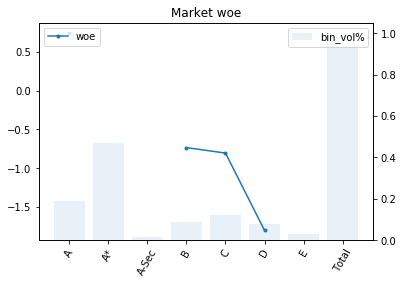

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv,var,desc
0,A,172.0,1.0,NaN,173.0,0.192179,0.090909,0.190949,0.748566,5.147494,0.005780,0.075807,Market,Fineclass
1,A*,425.0,0.0,NaN,425.0,0.474860,0.000000,0.469095,NaN,NaN,0.000000,NaN,Market,Fineclass
2,A-Sec,15.0,0.0,NaN,15.0,0.016760,0.000000,0.016556,NaN,NaN,0.000000,NaN,Market,Fineclass
3,B,78.0,2.0,NaN,80.0,0.087151,0.181818,0.088300,-0.735367,3.663562,0.025000,0.069615,Market,Fineclass
4,C,109.0,3.0,NaN,112.0,0.121788,0.272727,0.123620,-0.806193,3.592736,0.026786,0.121686,Market,Fineclass
5,D,67.0,5.0,NaN,72.0,0.074860,0.454545,0.079470,-1.803674,2.595255,0.069444,0.684828,Market,Fineclass
6,E,29.0,0.0,NaN,29.0,0.032402,0.000000,0.032009,NaN,NaN,0.000000,NaN,Market,Fineclass
7,Total,895.0,11.0,NaN,906.0,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.951937,Market,Fineclass


In [13]:
# var = 'Loan_purpose'
var = 'Market'

target = 'target'

#Fine class
s_num, s_cat = logreg_binning.split_num_cat(df[var])

s_num_fc, num_bin_edges_fc = logreg_binning.num_fc(s_num, bin_num_fineclass =20)
print('{} rows in s_num \n{} rows in s_cat'.format(len(s_num), len(s_cat)))
print('num bin edges: ', num_bin_edges_fc)

s_cat_fc, cat_bin_values_fc = logreg_binning.cat_fc(s_cat)
print('cat values: ', cat_bin_values_fc)

s_fc = logreg_binning.combine_num_cat_fc(s_num_fc, s_cat_fc)

eval_df_summary_fc = logreg_binning.bin_woe_iv(s_fc, df[target])

eval_df_summary_fc

#### STEP 2 - COARSECLASS and EVALUATION

input bin groups  [[0, 1, 2], [3, 4], [5, 6]]
output bin values  ['A, A*, A-Sec' 'B, C' 'D, E']
Custom Coarseclass - group categorical bins
IV is 1.888717960966924
total number of rows match


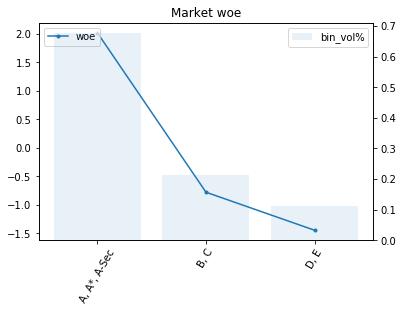

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv
0,"A, A*, A-Sec",612.0,1.0,NaN,613.0,0.683799,0.090909,0.676600,2.017804,6.416732,0.001631,1.196335
1,"B, C",187.0,5.0,NaN,192.0,0.208939,0.454545,0.211921,-0.777258,3.621671,0.026042,0.190900
2,"D, E",96.0,5.0,NaN,101.0,0.107263,0.454545,0.111479,-1.444018,2.954910,0.049505,0.501483


In [11]:
# Categorical coarse classing - Manual group categorical bins (Recommended for features with <10 bins)
s_cat_cc, cat_bin_values_cc = logreg_binning.cat_cc(s_cat, cat_bin_values = cat_bin_values_fc, \
                                                            cat_bin_values_groups = [[0, 1, 2], [3, 4], [5, 6]])

s_cc = logreg_binning.combine_num_cat_fc(s_num_fc, s_cat_cc)

eval_df_summary_cc = logreg_binning.bin_woe_iv(s_cc, df[target], desc = 'Custom Coarseclass - group categorical bins')

eval_df_summary_cc

### Example of smoothing woe for zero bad bin (Recommended for high cardinality features)

0 rows in s_num 
906 rows in s_cat
num bin edges:  []
cat values:  ['Business purposes' 'Car' 'Caravan' 'Consolidate existing debts'
 'Electronic goods (eg. Computer, TV, Audio)' 'Holiday'
 'Home improvements' 'House deposit' 'Motorbike' 'Other'
 'Pay off credit cards' 'Pay off loan from relative or friend' 'Repairs'
 'Tax bill' 'Wedding expenses']
Fineclass
IV is 0.45448044698647727
total number of rows match


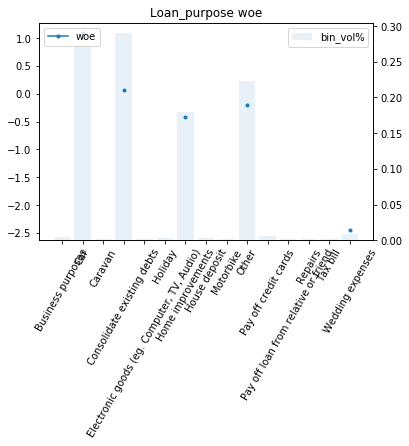

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv,smoothing_factor
0,Business purposes,4.0,0.0,NaN,4.0,0.004469,0.000000,0.004415,0.000000,NaN,0.000000,NaN,0.167982
1,Car,244.0,1.0,NaN,245.0,0.272626,0.090909,0.270419,1.098240,5.497168,0.004082,0.199568,1.000000
2,Caravan,1.0,0.0,NaN,1.0,0.001117,0.000000,0.001104,0.000000,NaN,0.000000,NaN,0.130108
3,Consolidate existing debts,260.0,3.0,NaN,263.0,0.290503,0.272727,0.290287,0.063141,4.462069,0.011407,0.001122,1.000000
4,"Electronic goods (eg. Computer, TV, Audio)",2.0,0.0,NaN,2.0,0.002235,0.000000,0.002208,0.000000,NaN,0.000000,NaN,0.141851
5,Holiday,3.0,0.0,NaN,3.0,0.003352,0.000000,0.003311,0.000000,NaN,0.000000,NaN,0.154465
6,Home improvements,160.0,3.0,NaN,163.0,0.178771,0.272727,0.179912,-0.422367,3.976562,0.018405,0.039684,0.999999
7,House deposit,3.0,0.0,NaN,3.0,0.003352,0.000000,0.003311,0.000000,NaN,0.000000,NaN,0.154465
8,Motorbike,2.0,0.0,NaN,2.0,0.002235,0.000000,0.002208,0.000000,NaN,0.000000,NaN,0.141851
9,Other,199.0,3.0,NaN,202.0,0.222346,0.272727,0.222958,-0.204236,4.194693,0.014851,0.010290,1.000000


In [12]:
var = 'Loan_purpose'
# var = 'Market'

target = 'target'

#Fine class
s_num, s_cat = logreg_binning.split_num_cat(df[var])

s_num_fc, num_bin_edges_fc = logreg_binning.num_fc(s_num, bin_num_fineclass =20)
print('{} rows in s_num \n{} rows in s_cat'.format(len(s_num), len(s_cat)))
print('num bin edges: ', num_bin_edges_fc)

s_cat_fc, cat_bin_values_fc = logreg_binning.cat_fc(s_cat)
print('cat values: ', cat_bin_values_fc)

s_fc = logreg_binning.combine_num_cat_fc(s_num_fc, s_cat_fc)

eval_df_summary_fc = logreg_binning.bin_woe_iv(s_fc, df[target])
    
eval_df_summary_cc = logreg_binning.cc_cat_zerobad_lowvolwoesmooth(cat_bin_values = cat_bin_values_fc, \
                                                                           eval_df_summary = eval_df_summary_fc, \
                                                                           min_samples_leaf=20, smoothing=10)
eval_df_summary_cc

#### STEP 3 - WOE ENCODING based on COARSECLASS

In [13]:
#for high cardinality feature, s_cc is not created and changes were only made to woe. so assign s_fc to s_cc
if s_cc is None or s_cc.name!=var:
    s_cc = s_fc

#convert s_cc to woe
s_cc_woe = logreg_binning.cc_to_woe(s_cc, eval_df_summary_cc)

s_cc_woe

woe encoding {'Business purposes': 0.0, 'Car': 1.098239779630906, 'Caravan': 0.0, 'Consolidate existing debts': 0.06314089686916755, 'Electronic goods (eg. Computer, TV, Audio)': 0.0, 'Holiday': 0.0, 'Home improvements': -0.42236665872799517, 'House deposit': 0.0, 'Motorbike': 0.0, 'Other': -0.20423590687343302, 'Pay off credit cards': 0.0, 'Pay off loan from relative or friend': 0.0, 'Repairs': 0.0, 'Tax bill': 0.0, 'Wedding expenses': -0.5678129412449616}


0     -0.204236
1     -0.204236
2      1.098240
3     -0.422367
4     -0.204236
         ...   
901    0.063141
902    0.063141
903    1.098240
904    0.063141
905    0.063141
Name: Loan_purpose_woe, Length: 906, dtype: float64

### Example of numeric variable

#### STEP 1 - FINECLASS and EVALUATION

num of bins is  16
906 rows in s_num 
0 rows in s_cat
num bin edges:  [-0.001   0.0674  0.0832  0.0936  0.109   0.125   0.141   0.158   0.174
  0.195   0.211   0.228   0.245   0.299   0.37    0.535   1.    ]
cat values:  []
Fineclass
IV is 1.8142556302368862
total number of rows match


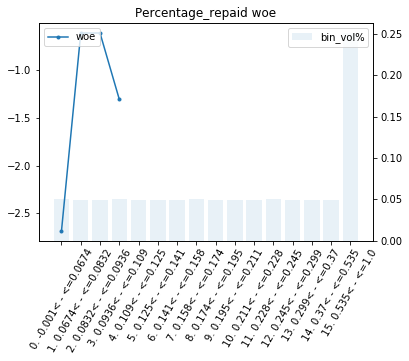

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv
0,0. -0.001< - <=0.0674,39.0,7.0,0,46.0,0.043575,0.636364,0.050773,-2.681277,1.717651,0.152174,1.589429
1,1. 0.0674< - <=0.0832,44.0,1.0,1,45.0,0.049162,0.090909,0.049669,-0.614739,3.784190,0.022222,0.025664
2,2. 0.0832< - <=0.0936,44.0,1.0,2,45.0,0.049162,0.090909,0.049669,-0.614739,3.784190,0.022222,0.025664
3,3. 0.0936< - <=0.109,44.0,2.0,3,46.0,0.049162,0.181818,0.050773,-1.307886,3.091042,0.043478,0.173499
4,4. 0.109< - <=0.125,45.0,0.0,4,45.0,0.050279,0.000000,0.049669,NaN,NaN,0.000000,NaN
5,5. 0.125< - <=0.141,45.0,0.0,5,45.0,0.050279,0.000000,0.049669,NaN,NaN,0.000000,NaN
6,6. 0.141< - <=0.158,45.0,0.0,6,45.0,0.050279,0.000000,0.049669,NaN,NaN,0.000000,NaN
7,7. 0.158< - <=0.174,46.0,0.0,7,46.0,0.051397,0.000000,0.050773,NaN,NaN,0.000000,NaN
8,8. 0.174< - <=0.195,45.0,0.0,8,45.0,0.050279,0.000000,0.049669,NaN,NaN,0.000000,NaN
9,9. 0.195< - <=0.211,45.0,0.0,9,45.0,0.050279,0.000000,0.049669,NaN,NaN,0.000000,NaN


In [14]:
# var = 'Borrower_rate'
# var = 'Transaction_price'
# var = 'Market'
# var = 'Days_in_arrears'
var = 'Percentage_repaid'
target = 'target'

s_num, s_cat = logreg_binning.split_num_cat(df[var])

s_num_fc, num_bin_edges_fc = logreg_binning.num_fc(s_num, bin_num_fineclass =20)
print('{} rows in s_num \n{} rows in s_cat'.format(len(s_num), len(s_cat)))
print('num bin edges: ', num_bin_edges_fc)

s_cat_fc, cat_bin_values_fc = logreg_binning.cat_fc(s_cat)
print('cat values: ', cat_bin_values_fc)

s_fc = logreg_binning.combine_num_cat_fc(s_num_fc, s_cat_fc)

eval_df_summary_fc = logreg_binning.bin_woe_iv(s_fc, df[target])
eval_df_summary_fc

#### STEP 2 - COARSECLASS and EVALUATION

Coarseclass Group 0 Bad bins
IV is 2.6901533874172134
total number of rows match


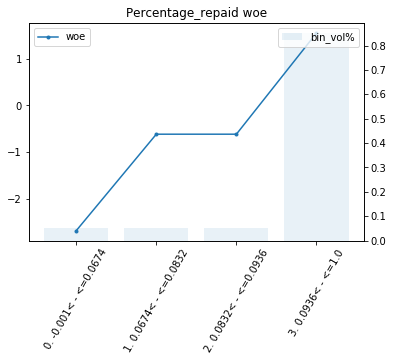

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv
0,0. -0.001< - <=0.0674,39.0,7.0,0,46.0,0.043575,0.636364,0.050773,-2.681277,1.717651,0.152174,1.589429
1,1. 0.0674< - <=0.0832,44.0,1.0,1,45.0,0.049162,0.090909,0.049669,-0.614739,3.784190,0.022222,0.025664
2,2. 0.0832< - <=0.0936,44.0,1.0,2,45.0,0.049162,0.090909,0.049669,-0.614739,3.784190,0.022222,0.025664
3,3. 0.0936< - <=1.0,768.0,2.0,3,770.0,0.858101,0.181818,0.849890,1.551714,5.950643,0.002597,1.049397


In [15]:
# Numeric coarse classing - group 0 Bad bins
num_bin_edges_cc = logreg_binning.num_cc_edges_nonzerobad(s_num, num_bin_edges_fc, eval_df_summary_fc)
s_num_cc = logreg_binning.num_cc(s_num, num_bin_edges_cc)

s_cc = logreg_binning.combine_num_cat_fc(s_num_cc, s_cat_fc)

eval_df_summary_cc = logreg_binning.bin_woe_iv(s_cc, df[target], desc = 'Coarseclass Group 0 Bad bins')
eval_df_summary_cc

feature and target correlation is -0.10136656807414093, woe should increase as feature increase
input bin edges :  [-0.001   0.0674  0.0832  0.0936  1.    ] 
 dropping index [2]
output bin edges :  [-0.001   0.0674  0.0936  1.    ]
Automatic Coarseclass group non-monotonic bins
IV is 2.690153387417213
total number of rows match


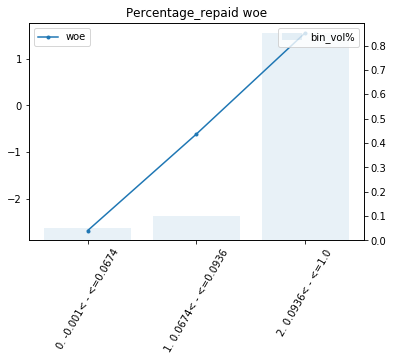

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv
0,0. -0.001< - <=0.0674,39.0,7.0,0,46.0,0.043575,0.636364,0.050773,-2.681277,1.717651,0.152174,1.589429
1,1. 0.0674< - <=0.0936,88.0,2.0,1,90.0,0.098324,0.181818,0.099338,-0.614739,3.784190,0.022222,0.051327
2,2. 0.0936< - <=1.0,768.0,2.0,2,770.0,0.858101,0.181818,0.849890,1.551714,5.950643,0.002597,1.049397


In [16]:
# Numeric coarse classing - Automatic group non-monotonic bins
num_bin_edges_cc = logreg_binning.num_cc_edges_woe_enforce_monotonicity(s_num, df[target], num_bin_edges = num_bin_edges_cc, eval_df_summary = eval_df_summary_cc)

s_num_cc = logreg_binning.num_cc(s_num, num_bin_edges_cc)

s_cc = logreg_binning.combine_num_cat_fc(s_num_cc, s_cat_fc)

eval_df_summary_cc = logreg_binning.bin_woe_iv(s_cc, df[target], desc = 'Automatic Coarseclass group non-monotonic bins')

eval_df_summary_cc

feature and target correlation is -0.10136656807414093, woe should increase as feature increase
input bin edges :  [-0.001   0.0674  0.0936  1.    ] 
 dropping index []
output bin edges :  [-0.001   0.0674  0.0936  1.    ]
Automatic Coarseclass group non-monotonic bins
IV is 2.690153387417213
total number of rows match


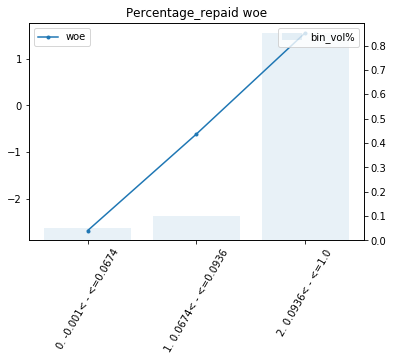

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv
0,0. -0.001< - <=0.0674,39.0,7.0,0,46.0,0.043575,0.636364,0.050773,-2.681277,1.717651,0.152174,1.589429
1,1. 0.0674< - <=0.0936,88.0,2.0,1,90.0,0.098324,0.181818,0.099338,-0.614739,3.784190,0.022222,0.051327
2,2. 0.0936< - <=1.0,768.0,2.0,2,770.0,0.858101,0.181818,0.849890,1.551714,5.950643,0.002597,1.049397


In [17]:
# Numeric coarse classing - Automatic group non-monotonic bins - Round 2
num_bin_edges_cc = logreg_binning.num_cc_edges_woe_enforce_monotonicity(s_num, df[target], num_bin_edges = num_bin_edges_cc, eval_df_summary = eval_df_summary_cc)

s_num_cc = logreg_binning.num_cc(s_num, num_bin_edges_cc)

s_cc = logreg_binning.combine_num_cat_fc(s_num_cc, s_cat_fc)

eval_df_summary_cc = logreg_binning.bin_woe_iv(s_cc, df[target], desc = 'Automatic Coarseclass group non-monotonic bins')

eval_df_summary_cc

input bin edges :  [-0.001   0.0674  0.0936  1.    ] 
 dropping  [0.0936]
output bin edges :  [-0.001   0.0674  1.    ]
Manual Coarseclass group non-monotonic bins
IV is 2.1626837873785387
total number of rows match


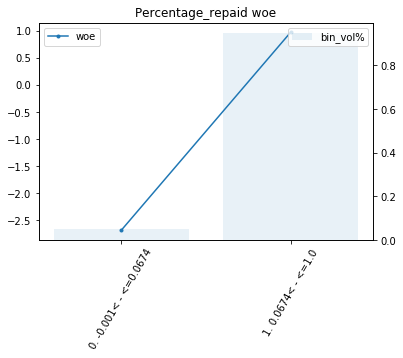

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv
0,0. -0.001< - <=0.0674,39.0,7.0,0,46.0,0.043575,0.636364,0.050773,-2.681277,1.717651,0.152174,1.589429
1,1. 0.0674< - <=1.0,856.0,4.0,1,860.0,0.956425,0.363636,0.949227,0.967048,5.365976,0.004651,0.573254


In [18]:
# Numeric coarse classing - Manual group non-monotonic bins
num_bin_edges_cc = logreg_binning.num_cc_edges_custom(num_bin_edges_cc, [[1, 2]])

s_num_cc = logreg_binning.num_cc(s_num, num_bin_edges_cc)

s_cc = logreg_binning.combine_num_cat_fc(s_num_cc, s_cat_fc)

eval_df_summary_cc = logreg_binning.bin_woe_iv(s_cc, df[target], desc = 'Manual Coarseclass group non-monotonic bins')

eval_df_summary_cc

#### STEP 3 - WOE ENCODING based on COARSECLASS

In [19]:
s_cc = logreg_binning.combine_num_cat_fc(s_num_cc, s_cat_fc)

s_cc_woe = logreg_binning.cc_to_woe(s_cc, eval_df_summary_cc)

s_cc_woe

woe encoding {'0. -0.001< - <=0.0674': -2.6812769484021515, '1. 0.0674< - <=1.0': 0.9670475695453666}


0     -2.681277
1      0.967048
2      0.967048
3     -2.681277
4     -2.681277
         ...   
901    0.967048
902    0.967048
903   -2.681277
904   -2.681277
905   -2.681277
Name: Percentage_repaid_woe, Length: 906, dtype: float64